In [ ]:
#importing libraries
import pandas as pd
import h5py
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import zipfile as zf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
import os
import pandas as pd
import cv2
import glob
import numpy as np
from glob import glob
import seaborn as sns

from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2D
from sklearn.metrics import classification_report

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Reading plant seedling data from Kaggle

In [ ]:

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/kaggle

/content/gdrive/My Drive/kaggle


In [ ]:
!pwd

/content/gdrive/My Drive/kaggle


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Processing /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674/kaggle-1.5.6-cp36-none-any.whl
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [ ]:
!kaggle competitions download -c plant-seedlings-classification

100% 1.68G/1.69G [00:49<00:00, 39.7MB/s]
100% 1.69G/1.69G [00:49<00:00, 36.9MB/s]


In [ ]:
!ls -l

total 1768243
-rw------- 1 root root         69 Aug 11 16:53 kaggle.json
-rw------- 1 root root 1810679877 Aug 20 07:38 plant-seedlings-classification.zip


In [ ]:
#extracting the zip file
train_zip = zf.ZipFile('plant-seedlings-classification.zip')
train_zip.extractall()
!ls

kaggle.json			    sample_submission.csv  train
plant-seedlings-classification.zip  test		   train.csv


Reading the downloaded data in Google drive and forming array of images and its lables 

In [ ]:
#forming image/labels array by reading data from google drive
images = []
classes=[]

df = pd.DataFrame(columns=['class','image_file'])
dfnew = pd.DataFrame(columns=['class','image_file'])
for class_folder in os.listdir("train"):
    class_folder_path = os.path.join("train", class_folder)
    #print(class_folder_path)
    for filename in glob(class_folder_path+"/*"):
      #print(filename)
      if(filename.endswith('.png')):
          im_dir = os.path.basename(class_folder_path)
          #print(im_dir)
          
        
          images.append(filename)
          #print(images)
          classes.append(im_dir)
          
          #Add record to the dataframe
          df.loc[df.shape[0]] = [im_dir,  filename]
          

In [ ]:
print(images[1:2])

['train/Black-grass/0183fdf68.png']


Exporting images and labels as dataframe of future use if required

In [ ]:
df.to_csv("train.csv",index=False)

In [ ]:
newdf = pd.read_csv("train.csv")

In [ ]:
newdf.head(2)

,class,image_file
0,Black-grass,train/Black-grass/0050f38b3.png
1,Black-grass,train/Black-grass/0183fdf68.png


In [ ]:
#Get class names
class_names = newdf['class'].unique().tolist()
class_names

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

Observing the number of classes in each group

In [ ]:
#total number of classes in each group
newdf.groupby('class').count()

,image_file
class,
Black-grass,263
Charlock,390
Cleavers,287
Common Chickweed,611
Common wheat,221
Fat Hen,475
Loose Silky-bent,654
Maize,221
Scentless Mayweed,516


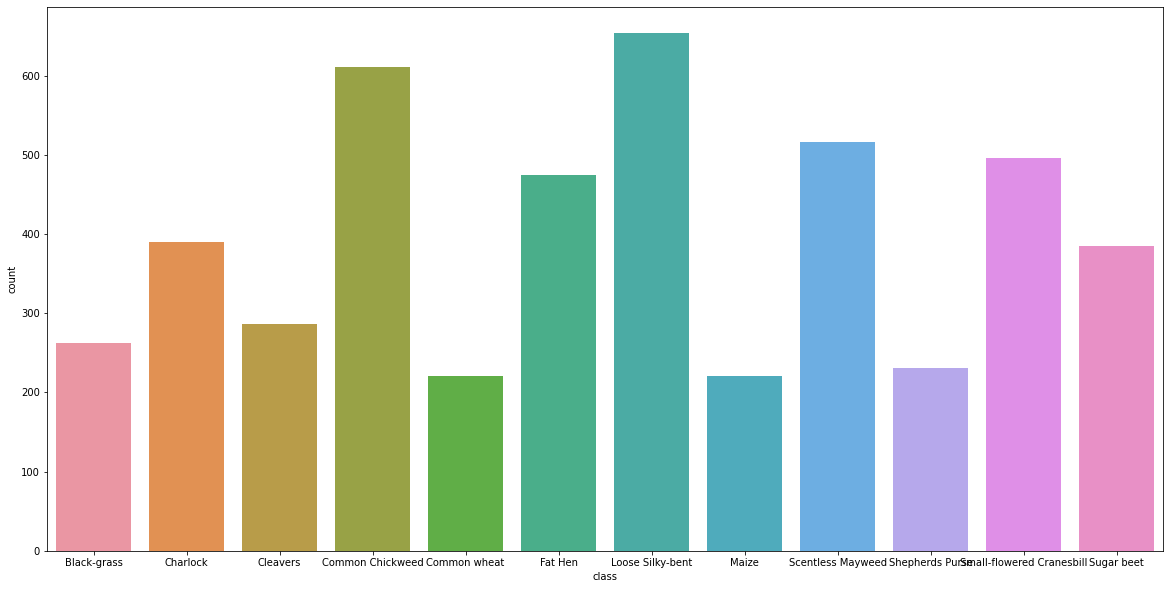

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(x = newdf['class'], data = newdf)

In [ ]:
import tensorflow as tf
import numpy as np

reading image using opencv

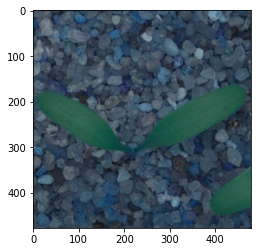

In [ ]:
#printing the image
from google.colab.patches import cv2_imshow
image_file = 'train/Sugar beet/ffa401155.png'
plant_image = cv2.imread(image_file)
plt.imshow(plant_image)
#Inspect image



In [ ]:
plantresize = cv2.resize(plant_image, dsize = (256,256),interpolation=cv2.INTER_AREA)

Viewing image after removing background noise by applying gaussianblur

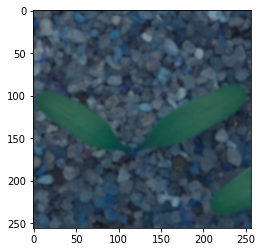

In [ ]:
newimage = cv2.GaussianBlur(plantresize,(5,5),0)
plt.imshow(newimage)

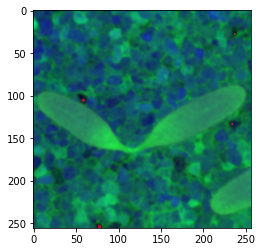

In [ ]:
#Create high intensity image
hsv = cv2.cvtColor(newimage, cv2.COLOR_BGR2HSV)

plt.imshow(hsv)


Image after masking the background

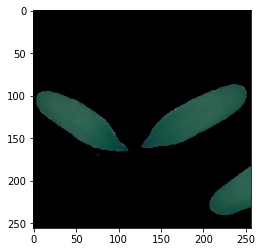

In [ ]:
# Create mask (parameters - green color range)
clearTrainImg = []
lower_green = (25, 35, 55)
upper_green = (80, 255, 255)
mask = cv2.inRange(hsv, lower_green, upper_green)  
mask1 = cv2.bitwise_and(newimage,newimage,mask = mask)

    

plt.imshow(mask1)

In [ ]:
newimage.shape

(256, 256, 3)

Reading image through opencv and reshaping it .

In [ ]:

img_array = []
labels = []
#print(images)
#print(images[2])
#print(images.split('/',1))
for imgl in range(len(images)):
  #print(imgl)
  output = []
  #ignoring 2900 image as it is unable to read it
  if imgl == 2900:
    print(imgl)
  else:
    imgf = cv2.imread(images[imgl])
   # dsize
    dsize = (214,214)
    #print(dsize)
  # resize image
    outputf = cv2.resize(imgf, dsize = dsize,interpolation=cv2.INTER_AREA)
    #newimage = cv2.GaussianBlur(output,(5,5),0)
    #img = load_img(images[imgl])
    img_array.append(outputf)
    labels.append(classes[imgl])
  
 
# convert to numpy arr ay
 

2900


In [ ]:
sampledf = pd.DataFrame(columns = ['imgfile','labels'])

In [ ]:
sampledf['imgfile'] = img_array
sampledf['labels'] = labels


In [ ]:
sampledf.to_csv('sampledf.csv',index = False)

In [ ]:
labels[1:2]

['Black-grass']

Converting string class names into labels in encoded form

In [ ]:

#code = np.array(labels)

label_encoder = LabelEncoder()
convlabel = label_encoder.fit_transform(labels)

In [ ]:
convlabel[2000:2012]

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [ ]:
len(img_array)


4749

Forming train test data

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(img_array,convlabel,test_size=0.20,random_state=42)

In [ ]:
X_train[0].shape

(214, 214, 3)

Converting labels into categorical form

In [ ]:
y_trainc = tf.keras.utils.to_categorical(y_train)
y_testc = tf.keras.utils.to_categorical(y_test)

The converting image into numpy array before feeding it into the model

In [ ]:

X_trains = np.array(X_train).astype('float32')/255.0
X_tests = np.array(X_test).astype('float32')/255.0


Checking the length of train and validation set

In [ ]:
len(X_train), len(X_test)

(3799, 950)

In [ ]:
len(y_train),len(y_test)

(3799, 950)

STEP1 : Building Fully connected layer model without CNN to check the model performance

In [ ]:
model1 = keras.Sequential()
model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.BatchNormalization())

#hidden layer1 
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(1000,activation = 'relu'))
model1.add(tf.keras.layers.Dropout(0.02))
#hidden layer2
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(1000,activation = 'relu'))
model1.add(tf.keras.layers.Dropout(0.02))

#hidden layer3
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(500,activation = 'relu'))
model1.add(tf.keras.layers.Dropout(0.02))

#output layer
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
model1.add(tf.keras.layers.Dense(12,activation = 'softmax'))
model1.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=["accuracy"])


In [ ]:
output1 = model1.fit(X_trains, y_trainc, validation_data=(X_tests, y_testc), epochs=30, batch_size = 30,callbacks=[callback])

Epoch 1/30
127/127 [==============================] - 10s 80ms/step - loss: 1.9697 - accuracy: 0.3651 - val_loss: 2.3795 - val_accuracy: 0.1105
Epoch 2/30
127/127 [==============================] - 9s 72ms/step - loss: 0.8444 - accuracy: 0.7389 - val_loss: 2.1547 - val_accuracy: 0.2505
Epoch 3/30
127/127 [==============================] - 9s 72ms/step - loss: 0.4729 - accuracy: 0.8789 - val_loss: 1.6809 - val_accuracy: 0.4189
Epoch 4/30
127/127 [==============================] - 9s 70ms/step - loss: 0.2742 - accuracy: 0.9376 - val_loss: 1.3354 - val_accuracy: 0.5411
Epoch 5/30
127/127 [==============================] - 9s 70ms/step - loss: 0.1478 - accuracy: 0.9792 - val_loss: 1.2394 - val_accuracy: 0.5874
Epoch 6/30
127/127 [==============================] - 9s 69ms/step - loss: 0.1006 - accuracy: 0.9895 - val_loss: 1.2908 - val_accuracy: 0.5853
Epoch 7/30
127/127 [==============================] - 9s 70ms/step - loss: 0.0668 - accuracy: 0.9939 - val_loss: 1.2935 - val_accuracy: 0.587

From the above we could find out that model is highly overfitting only with fully connected layer.training accuracy is 100% and validation accuracy is 59%. We wil introduce Convolutional layers in our model


Train: 1.000, Test: 0.591


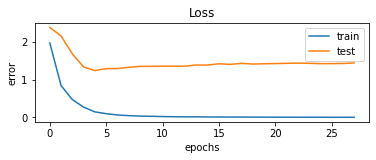

In [ ]:
trainloss1, trainaccuracy1 = model1.evaluate(X_trains, y_trainc, verbose=0)
testloss1,testaccuracy1 = model1.evaluate(X_tests, y_testc, verbose=0)
print('Train: %.3f, Test: %.3f' % (trainaccuracy1, testaccuracy1))
# plot loss during training

pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(output1.history['loss'], label='train')
pyplot.plot(output1.history['val_loss'], label='test')
pyplot.xlabel('epochs')
pyplot.ylabel('error')

pyplot.legend()

**The model built using feed forward network is highly overfitting. We will use CNN to check the model performance**

STEP2: Including Convolutional layer in the model


In [ ]:
#Initialize the model
model = keras.Sequential()

#Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'ReLU' 
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 name='conv_1'))

#Add a Convolutional Layer with 64 filters of size 3X3 and activation function as 'ReLU' 
model.add(Conv2D(32, (3, 3), activation='relu',name='conv_2'))


model.add(Flatten())

#Add Fully Connected Layer with 128 units and activation function as 'ReLU'
model.add(Dense(128, activation='relu',name='dense_1'))



#Add Fully Connected Layer with 10 units and activation function as 'softmax'
model.add(Dense(12, activation='softmax',name='dense_2'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
#Training on the dataset
model.fit(X_trains, y_trainc,
          batch_size=50,
          epochs=5,
          verbose=1,
          validation_data=(X_tests, y_testc))

Epoch 1/5
76/76 [==============================] - 6s 83ms/step - loss: 6.0339 - accuracy: 0.2314 - val_loss: 1.9283 - val_accuracy: 0.4379
Epoch 2/5
76/76 [==============================] - 6s 78ms/step - loss: 1.7069 - accuracy: 0.4730 - val_loss: 1.6968 - val_accuracy: 0.4989
Epoch 3/5
76/76 [==============================] - 6s 78ms/step - loss: 1.4251 - accuracy: 0.5620 - val_loss: 1.5877 - val_accuracy: 0.5126
Epoch 4/5
76/76 [==============================] - 6s 79ms/step - loss: 1.1528 - accuracy: 0.6404 - val_loss: 1.5560 - val_accuracy: 0.5653
Epoch 5/5
76/76 [==============================] - 6s 78ms/step - loss: 0.9114 - accuracy: 0.7091 - val_loss: 1.5369 - val_accuracy: 0.5684


Model still overfits without dropout layers

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 212, 212, 32)      896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 210, 210, 32)      9248      
_________________________________________________________________
flatten (Flatten)            (None, 1411200)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               180633728 
_________________________________________________________________
dense_2 (Dense)              (None, 12)                1548      
Total params: 180,645,420
Trainable params: 180,645,420
Non-trainable params: 0
_________________________________________________________________


STEP3 : Introducing drop out layers in the model

In [ ]:
#Initialize the model
model2 = keras.Sequential()

#Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'ReLU' 
model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 name='conv_1'))

#Add a Convolutional Layer with 64 filters of size 3X3 and activation function as 'ReLU' 
model2.add(Conv2D(32, (3, 3), activation='relu',name='conv_2'))
model2.add(MaxPooling2D(pool_size=(2, 2),name='max_1'))
model2.add(Dropout(0.25,name='drop_1'))


model2.add(Flatten())

#Add Fully Connected Layer with 128 units and activation function as 'ReLU'
model2.add(Dense(128, activation='relu',name='dense_1'))

model2.add(Dropout(0.25,name='drop_2'))

#Add Fully Connected Layer with 10 units and activation function as 'softmax'
model2.add(Dense(12, activation='softmax',name='dense_2'))
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
#Training on the dataset
model2.fit(X_trains, y_trainc,
          batch_size=50,
          epochs=5,
          verbose=1,
          validation_data=(X_tests, y_testc))

Epoch 1/5
76/76 [==============================] - 5s 61ms/step - loss: 3.2027 - accuracy: 0.2287 - val_loss: 1.7709 - val_accuracy: 0.4453
Epoch 2/5
76/76 [==============================] - 5s 59ms/step - loss: 1.6912 - accuracy: 0.4188 - val_loss: 1.5894 - val_accuracy: 0.4495
Epoch 3/5
76/76 [==============================] - 5s 59ms/step - loss: 1.4733 - accuracy: 0.4938 - val_loss: 1.3648 - val_accuracy: 0.5474
Epoch 4/5
76/76 [==============================] - 4s 59ms/step - loss: 1.3314 - accuracy: 0.5346 - val_loss: 1.3126 - val_accuracy: 0.5684
Epoch 5/5
76/76 [==============================] - 4s 59ms/step - loss: 1.2245 - accuracy: 0.5588 - val_loss: 1.2940 - val_accuracy: 0.5558


Inroduction of drop out layer had reduced the overfitting of the model

In [ ]:
#Initialize the model
from keras.layers import BatchNormalization
model3 = keras.Sequential()

#Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'ReLU' 
model3.add(BatchNormalization())
model3.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 name='conv_1'))

#Add a Convolutional Layer with 64 filters of size 3X3 and activation function as 'ReLU' 
model3.add(Conv2D(32, (3, 3), activation='relu',name='conv_2'))
model3.add(MaxPooling2D(pool_size=(2, 2),name='max_1'))
model3.add(Dropout(0.25,name='drop_1'))


model3.add(Flatten())
model3.add(BatchNormalization())
#Add Fully Connected Layer with 128 units and activation function as 'ReLU'
model3.add(Dense(128, activation='relu',name='dense_1'))

model3.add(Dropout(0.25,name='drop_2'))

#Add Fully Connected Layer with 10 units and activation function as 'softmax'
model3.add(Dense(12, activation='softmax',name='dense_2'))
model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
#Training on the dataset
model3.fit(X_trains, y_trainc,
          batch_size=50,
          epochs=5,
          verbose=1,
          validation_data=(X_tests, y_testc))

Epoch 1/5
76/76 [==============================] - 6s 75ms/step - loss: 13.9087 - accuracy: 0.4077 - val_loss: 2.7059 - val_accuracy: 0.0463
Epoch 2/5
76/76 [==============================] - 6s 73ms/step - loss: 1.7862 - accuracy: 0.6496 - val_loss: 2.4485 - val_accuracy: 0.1179
Epoch 3/5
76/76 [==============================] - 6s 73ms/step - loss: 0.7596 - accuracy: 0.7905 - val_loss: 2.5402 - val_accuracy: 0.1368
Epoch 4/5
76/76 [==============================] - 6s 73ms/step - loss: 0.5030 - accuracy: 0.8602 - val_loss: 3.2779 - val_accuracy: 0.1642
Epoch 5/5
76/76 [==============================] - 6s 73ms/step - loss: 0.5023 - accuracy: 0.8710 - val_loss: 2.4886 - val_accuracy: 0.2958


Step4 : Introducing batchnormalization along with the drop out layer ,trying different combinations of model with and without drop out layers.

In [ ]:
#Initialize the model
from keras.layers import BatchNormalization
model4 = keras.Sequential()

#Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'ReLU' 
model4.add(BatchNormalization())
model4.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 name='conv_1'))

#Add a Convolutional Layer with 64 filters of size 3X3 and activation function as 'ReLU' 
model4.add(Conv2D(32, (3, 3), activation='relu',name='conv_2'))
model4.add(MaxPooling2D(pool_size=(2, 2),name='max_1'))
model4.add(Dropout(0.25,name ='drop_1'))

model4.add(Conv2D(64, kernel_size=(3, 3), activation='relu', name='conv_3'))

#Add a Convolutional Layer with 64 filters of size 3X3 and activation function as 'ReLU' 
model4.add(Conv2D(64, (3, 3), activation='relu',name='conv_4'))
model4.add(MaxPooling2D(pool_size=(2, 2),name='max_2'))
model4.add(Dropout(0.25,name ='drop_2'))
model4.add(Flatten())
model4.add(BatchNormalization())
#Add Fully Connected Layer with 128 units and activation function as 'ReLU'
model4.add(Dense(128, activation='relu',name='dense_1'))

model4.add(Dropout(0.25,name ='drop_3'))

#Add Fully Connected Layer with 10 units and activation function as 'softmax'
model4.add(Dense(12, activation='softmax',name='dense_2'))
model4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
#Training on the dataset
model4.fit(X_trains, y_trainc,
          batch_size=50,
          epochs=5,
          verbose=1,
          validation_data=(X_tests, y_testc))

Epoch 1/5
76/76 [==============================] - 8s 101ms/step - loss: 2.8049 - accuracy: 0.4399 - val_loss: 2.5966 - val_accuracy: 0.0705
Epoch 2/5
76/76 [==============================] - 7s 96ms/step - loss: 1.0038 - accuracy: 0.6773 - val_loss: 3.5348 - val_accuracy: 0.1600
Epoch 3/5
76/76 [==============================] - 7s 96ms/step - loss: 0.7045 - accuracy: 0.7742 - val_loss: 4.4910 - val_accuracy: 0.1495
Epoch 4/5
76/76 [==============================] - 7s 96ms/step - loss: 0.4467 - accuracy: 0.8518 - val_loss: 2.7749 - val_accuracy: 0.2232
Epoch 5/5
76/76 [==============================] - 7s 96ms/step - loss: 0.2730 - accuracy: 0.9108 - val_loss: 2.4616 - val_accuracy: 0.3884


In [ ]:
#Initialize the model
#uing sgd optimizer
model5 = keras.Sequential()

#Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'ReLU' 
model5.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 name='conv_1'))

#Add a Convolutional Layer with 64 filters of size 3X3 and activation function as 'ReLU' 
model5.add(Conv2D(32, (3, 3), activation='relu',name='conv_2'))
model5.add(MaxPooling2D(pool_size=(2, 2),name='max_1'))
model5.add(Dropout(0.25,name='drop_1'))


model5.add(Flatten())

#Add Fully Connected Layer with 128 units and activation function as 'ReLU'
model5.add(Dense(128, activation='relu',name='dense_1'))

model5.add(Dropout(0.25,name='drop_3'))

#Add Fully Connected Layer with 10 units and activation function as 'softmax'
model5.add(Dense(12, activation='softmax',name='dense_2'))
model5.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
#Training on the dataset
model5.fit(X_trains, y_trainc,
          batch_size=50,
          epochs=5,
          verbose=1,
          validation_data=(X_tests, y_testc))

Epoch 1/5
76/76 [==============================] - 5s 60ms/step - loss: 2.4143 - accuracy: 0.1574 - val_loss: 2.3491 - val_accuracy: 0.2274
Epoch 2/5
76/76 [==============================] - 4s 58ms/step - loss: 2.3106 - accuracy: 0.2056 - val_loss: 2.2333 - val_accuracy: 0.2158
Epoch 3/5
76/76 [==============================] - 4s 58ms/step - loss: 2.1480 - accuracy: 0.2830 - val_loss: 1.9098 - val_accuracy: 0.3568
Epoch 4/5
76/76 [==============================] - 4s 58ms/step - loss: 1.9804 - accuracy: 0.3219 - val_loss: 1.8351 - val_accuracy: 0.3989
Epoch 5/5
76/76 [==============================] - 4s 58ms/step - loss: 1.7632 - accuracy: 0.3943 - val_loss: 1.5692 - val_accuracy: 0.4642


In [ ]:
#Initialize the model
model6 = keras.Sequential()

#Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'ReLU' 
model6.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 name='conv_1'))

#Add a Convolutional Layer with 64 filters of size 3X3 and activation function as 'ReLU' 
model6.add(Conv2D(32, (3, 3), activation='relu',name='conv_2'))
model6.add(MaxPooling2D(pool_size=(2, 2),name='max_1'))
model6.add(Dropout(0.25,name='drop_1'))


model6.add(Flatten())

#Add Fully Connected Layer with 128 units and activation function as 'ReLU'
model6.add(Dense(128, activation='relu',name='dense_1'))

model6.add(Dropout(0.25,name='drop_3'))

#Add Fully Connected Layer with 10 units and activation function as 'softmax'
model6.add(Dense(12, activation='softmax',name='dense_2'))
model6.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
model6.fit(X_trains, y_trainc,
          batch_size=50,
          epochs=10,
          verbose=1,
          validation_data=(X_tests, y_testc))

Epoch 1/10
76/76 [==============================] - 5s 66ms/step - loss: 3.5626 - accuracy: 0.2561 - val_loss: 4.0118 - val_accuracy: 0.1505
Epoch 2/10
76/76 [==============================] - 5s 64ms/step - loss: 1.7924 - accuracy: 0.4327 - val_loss: 1.3660 - val_accuracy: 0.5347
Epoch 3/10
76/76 [==============================] - 5s 64ms/step - loss: 1.3727 - accuracy: 0.5628 - val_loss: 1.3395 - val_accuracy: 0.5632
Epoch 4/10
76/76 [==============================] - 5s 64ms/step - loss: 1.0585 - accuracy: 0.6618 - val_loss: 1.1911 - val_accuracy: 0.6211
Epoch 5/10
76/76 [==============================] - 5s 64ms/step - loss: 0.7564 - accuracy: 0.7639 - val_loss: 1.1987 - val_accuracy: 0.6389
Epoch 6/10
76/76 [==============================] - 5s 64ms/step - loss: 0.5592 - accuracy: 0.8257 - val_loss: 1.1860 - val_accuracy: 0.6463
Epoch 7/10
76/76 [==============================] - 5s 64ms/step - loss: 0.3956 - accuracy: 0.8810 - val_loss: 1.2708 - val_accuracy: 0.6453
Epoch 8/10
76

As still overfitting has not reduced, introducing image augmentation techniques to reduce the overfitting and improve model performace.
Model performace is better with Adam optimizer than SGD,RMSProp. We will be using adam in our model


In [ ]:
#Define Training Data Generator with augmentations
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=40,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=False,
                                                                fill_mode = 'nearest',                                                                
                                                                ) 
#

In [ ]:
#fitting train data with image generator
img_generator.fit(X_trains)

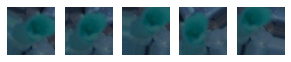

In [ ]:
#viewing image generated using augmentation techniques
from matplotlib import pyplot as plt
gen = img_generator.flow(X_trains[0:1], batch_size=1)
for i in range(1, 6):
    plt.subplot(1,6,i)
    plt.axis("off")
    plt.imshow(gen.next().squeeze(), cmap='gray')
    plt.plot()
plt.show()

In [ ]:
output2 = model2.fit_generator(img_generator.flow(X_trains,y_trainc),
                    epochs=10,
                    steps_per_epoch=3799/70,  #Number of training images//batch_size
                    validation_data=(X_tests,y_testc),
                    validation_steps = 950//70, #Number of test images//batch_size
                   )

Epoch 1/10
55/54 [==============================] - 16s 282ms/step - loss: 1.6124 - accuracy: 0.4369 - val_loss: 1.3112 - val_accuracy: 0.5316
Epoch 2/10
55/54 [==============================] - 15s 279ms/step - loss: 1.6330 - accuracy: 0.4249 - val_loss: 1.2526 - val_accuracy: 0.5558
Epoch 3/10
55/54 [==============================] - 16s 283ms/step - loss: 1.5904 - accuracy: 0.4557 - val_loss: 1.2843 - val_accuracy: 0.5379
Epoch 4/10
55/54 [==============================] - 15s 278ms/step - loss: 1.5926 - accuracy: 0.4335 - val_loss: 1.2385 - val_accuracy: 0.5811
Epoch 5/10
55/54 [==============================] - 15s 277ms/step - loss: 1.6055 - accuracy: 0.4489 - val_loss: 1.2444 - val_accuracy: 0.5653
Epoch 6/10
55/54 [==============================] - 15s 278ms/step - loss: 1.5538 - accuracy: 0.4551 - val_loss: 1.2855 - val_accuracy: 0.5495
Epoch 7/10
55/54 [==============================] - 15s 274ms/step - loss: 1.5749 - accuracy: 0.4506 - val_loss: 1.2561 - val_accuracy: 0.5684

In [ ]:
img_generator1 = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip = True,                                                                
                                                                ) 
img_generator1.fit(X_trains)

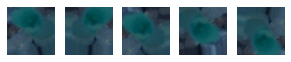

In [ ]:
from matplotlib import pyplot as plt
gen1 = img_generator1.flow(X_trains[0:1], batch_size=1)
for i in range(1, 6):
    plt.subplot(1,6,i)
    plt.axis("off")
    plt.imshow(gen1.next().squeeze(), cmap='gray')
    plt.plot()
plt.show()

In [ ]:
output2 = model2.fit_generator(img_generator1.flow(X_trains,y_trainc),
                    epochs=10,
                    steps_per_epoch=3799/70,  #Number of training images//batch_size
                    validation_data=(X_tests,y_testc),
                    validation_steps = 950//70, #Number of test images//batch_size
                   )

Epoch 1/10
55/54 [==============================] - 15s 271ms/step - loss: 1.5121 - accuracy: 0.4694 - val_loss: 1.1687 - val_accuracy: 0.5842
Epoch 2/10
55/54 [==============================] - 15s 268ms/step - loss: 1.5061 - accuracy: 0.4849 - val_loss: 1.1777 - val_accuracy: 0.5789
Epoch 3/10
55/54 [==============================] - 15s 268ms/step - loss: 1.5002 - accuracy: 0.4677 - val_loss: 1.1651 - val_accuracy: 0.5989
Epoch 4/10
55/54 [==============================] - 15s 269ms/step - loss: 1.5214 - accuracy: 0.4592 - val_loss: 1.2602 - val_accuracy: 0.5558
Epoch 5/10
55/54 [==============================] - 15s 271ms/step - loss: 1.4708 - accuracy: 0.4812 - val_loss: 1.1599 - val_accuracy: 0.5989
Epoch 6/10
55/54 [==============================] - 15s 268ms/step - loss: 1.4574 - accuracy: 0.4881 - val_loss: 1.1957 - val_accuracy: 0.5905
Epoch 7/10
55/54 [==============================] - 15s 273ms/step - loss: 1.5141 - accuracy: 0.4790 - val_loss: 1.1702 - val_accuracy: 0.6000

In [ ]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/kaggle/train/plant.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

Image augmentation helps in reducing overfitting

Step : 5 Building New Model with four convolution layer with 32,64 filter of kernal size 3*3, also using maxpooling layer and using fully connected layer at the end

In [ ]:
import tensorflow as tf
from keras.layers import BatchNormalization
tf.keras.backend.clear_session()
#Initialize the model
model7 = keras.Sequential()

#Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'ReLU' 

model7.add(Conv2D(32, kernel_size=(3, 3),activation='relu',name='conv_1'))
model7.add(Conv2D(32, (3, 3), activation='relu',name='conv_2'))
model7.add(MaxPooling2D(pool_size=(2, 2),name='max_1'))
model7.add(Dropout(0.25,name='drop_1'))


model7.add(Conv2D(64, kernel_size=(3, 3),activation='relu',name='conv_3'))
model7.add(Conv2D(64, (3, 3), activation='relu',name='conv_4'))
model7.add(MaxPooling2D(pool_size=(2, 2),name='max_2'))
model7.add(Dropout(0.25,name='drop_2'))

model7.add(Flatten())
model7.add(BatchNormalization())
model7.add(Dense(128, activation='relu',name='dense_1'))
model7.add(Dropout(0.25,name='drop_6'))
model7.add(Dense(12, activation='softmax',name='dense_2'))
model7.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5,verbose = 1,mode ='auto')
output7 = model7.fit_generator(img_generator1.flow(X_trains,y_trainc),
                    epochs=10,
                    steps_per_epoch=3799/50,  #Number of training images//batch_size
                    validation_data=(X_tests,y_testc),
                    validation_steps = 950//50, #Number of test images//batch_size
                    callbacks = [model_checkpoint,callback]
                   )

Epoch 1/10
76/75 [==============================] - ETA: 0s - loss: 2.2071 - accuracy: 0.2670WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0098s vs `on_test_batch_end` time: 0.0178s). Check your callbacks.

Epoch 00001: val_accuracy did not improve from 0.14737
76/75 [==============================] - 21s 274ms/step - loss: 2.2071 - accuracy: 0.2670 - val_loss: 2.4405 - val_accuracy: 0.0842
Epoch 2/10
76/75 [==============================] - ETA: 0s - loss: 1.7967 - accuracy: 0.3840
Epoch 00002: val_accuracy improved from 0.14737 to 0.15368, saving model to /content/gdrive/My Drive/kaggle/train/plant.h5
76/75 [==============================] - 22s 286ms/step - loss: 1.7967 - accuracy: 0.3840 - val_loss: 2.3943 - val_accuracy: 0.1537
Epoch 3/10
76/75 [==============================] - ETA: 0s - loss: 1.6719 - accuracy: 0.4433
Epoch 00003: val_accuracy did not improve from 0.15368
76/75 [==============================] - 21s 278

In [ ]:
output8 = model7.fit_generator(img_generator1.flow(X_trains,y_trainc),
                    epochs=100,
                    initial_epoch =10,
                    steps_per_epoch=3799/50,  #Number of training images//batch_size
                    validation_data=(X_tests,y_testc),
                    validation_steps = 950//50, #Number of test images//batch_size
                    callbacks = [model_checkpoint,callback]
                   )

Epoch 11/100
76/75 [==============================] - ETA: 0s - loss: 1.2209 - accuracy: 0.5766WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0080s vs `on_test_batch_end` time: 0.0179s). Check your callbacks.

Epoch 00011: val_accuracy did not improve from 0.60947
76/75 [==============================] - 20s 268ms/step - loss: 1.2209 - accuracy: 0.5766 - val_loss: 1.2546 - val_accuracy: 0.5421
Epoch 12/100
76/75 [==============================] - ETA: 0s - loss: 1.2751 - accuracy: 0.5720
Epoch 00012: val_accuracy did not improve from 0.60947
76/75 [==============================] - 20s 268ms/step - loss: 1.2751 - accuracy: 0.5720 - val_loss: 3.6706 - val_accuracy: 0.2358
Epoch 13/100
76/75 [==============================] - ETA: 0s - loss: 1.2429 - accuracy: 0.5774
Epoch 00013: val_accuracy improved from 0.60947 to 0.69789, saving model to /content/gdrive/My Drive/kaggle/train/plant.h5
76/75 [==============================] - 2

Model performance is better with image augmentation. 

Train: 0.833, Test: 0.816


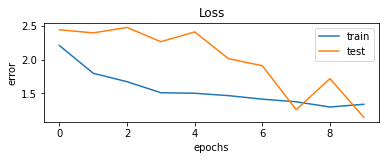

In [ ]:
trainloss1, trainaccuracy1 = model7.evaluate(X_trains, y_trainc, verbose=0)
testloss1,testaccuracy1 = model7.evaluate(X_tests, y_testc, verbose=0)
print('Train: %.3f, Test: %.3f' % (trainaccuracy1, testaccuracy1))
# plot loss during training

pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(output7.history['loss'], label='train')
pyplot.plot(output7.history['val_loss'], label='test')
pyplot.xlabel('epochs')
pyplot.ylabel('error')

pyplot.legend()

In [ ]:
#Saving the best model using model checkpoint callback
model_checkpoint1=tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/kaggle/train/plant6.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

Step 6 :Introducing padding and strides.
Convolutional layer : 12 and 2 fully connected layer.
Initially running for 100 epochs


In [ ]:
import tensorflow as tf
from keras.layers import BatchNormalization
tf.keras.backend.clear_session()
#Initialize the model
model8 = keras.Sequential()

#Add a Convolutional Layer with 32 filters of size 11X11 and activation function as 'ReLU' 
model8.add(BatchNormalization())

model8.add(Conv2D(32, kernel_size=(11, 11),activation='relu',name='conv_1' , padding = 'same',strides = (2,2)))
model8.add(Conv2D(32, (11, 11), activation='relu',name='conv_2',padding = 'same',strides = (2,2)))
model8.add(Conv2D(64, kernel_size=(7, 7),activation='relu',name='conv_3',padding = 'same',strides = (2,2)))
model8.add(MaxPooling2D(pool_size=(2, 2),name='max_1'))
model8.add(Dropout(0.25,name='drop_1'))

model8.add(BatchNormalization())

#Add a Convolutional Layer with 64 filters of size 5X5 and activation function as 'ReLU' 
model8.add(Conv2D(64, kernel_size=(5, 5),activation='relu',name='conv_4',padding = 'same'))
model8.add(Conv2D(64, (5, 5), activation='relu',name='conv_5',padding = 'same'))
model8.add(Conv2D(128, (3, 3), activation='relu',name='conv_6',padding = 'same'))
model8.add(MaxPooling2D(pool_size=(2, 2),name='max_3'))
model8.add(Dropout(0.25,name='drop_2'))

model8.add(BatchNormalization())

#Add a Convolutional Layer with 128 filters of size 3*3 and activation function as 'ReLU' 
model8.add(Conv2D(128, kernel_size=(3, 3),activation='relu',name='conv_7',padding = 'same'))
model8.add(Conv2D(128, (3, 3), activation='relu',name='conv_8',padding = 'same'))
model8.add(Conv2D(256, (3, 3), activation='relu',name='conv_9',padding = 'same'))
model8.add(MaxPooling2D(pool_size=(2, 2),name='max_4'))
model8.add(Dropout(0.25,name='drop_3'))


model8.add(BatchNormalization())
#Add a Convolutional Layer with 256 filters of size 3*3 and activation function as 'ReLU' 

model8.add(Conv2D(256, kernel_size=(3, 3),activation='relu',name='conv_10',padding = 'same'))
model8.add(Conv2D(256, (3, 3), activation='relu',name='conv_11',padding = 'same'))
model8.add(Conv2D(516, (3, 3), activation='relu',name='conv_12',padding = 'same'))
model8.add(MaxPooling2D(pool_size=(2, 2),name='max_5'))
model8.add(Dropout(0.25,name='drop_4'))

model8.add(Flatten())
model8.add(BatchNormalization())
model8.add(Dense(1000, activation='relu',name='dense_1'))
model8.add(Dropout(0.1,name='drop_5'))
model8.add(Dense(12, activation='softmax',name='dense_2'))
model8.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5,verbose = 1,mode ='auto')
output8 = model8.fit_generator(img_generator1.flow(X_trains,y_trainc),
                    epochs=100,
                    steps_per_epoch=3799/50,  #Number of training images//batch_size
                    validation_data=(X_tests,y_testc),
                    validation_steps = 950//50, #Number of test images//batch_size
                    callbacks = [model_checkpoint1,callback]
                   )

Epoch 1/100
76/75 [==============================] - ETA: 0s - loss: 2.6100 - accuracy: 0.1527
Epoch 00001: val_accuracy improved from -inf to 0.14737, saving model to /content/gdrive/My Drive/kaggle/train/plant6.h5
76/75 [==============================] - 23s 302ms/step - loss: 2.6100 - accuracy: 0.1527 - val_loss: 16.7559 - val_accuracy: 0.1474
Epoch 2/100
76/75 [==============================] - ETA: 0s - loss: 2.1264 - accuracy: 0.2522
Epoch 00002: val_accuracy did not improve from 0.14737
76/75 [==============================] - 22s 284ms/step - loss: 2.1264 - accuracy: 0.2522 - val_loss: 16.2480 - val_accuracy: 0.0705
Epoch 3/100
76/75 [==============================] - ETA: 0s - loss: 2.0085 - accuracy: 0.2967
Epoch 00003: val_accuracy improved from 0.14737 to 0.20947, saving model to /content/gdrive/My Drive/kaggle/train/plant6.h5
76/75 [==============================] - 22s 295ms/step - loss: 2.0085 - accuracy: 0.2967 - val_loss: 5.2926 - val_accuracy: 0.2095
Epoch 4/100
76/75

In [ ]:
#running for 250 epochs
output9 = model8.fit_generator(img_generator1.flow(X_trains,y_trainc),
                    epochs=250,
                    initial_epoch =100,
                    steps_per_epoch=3799/50,  #Number of training images//batch_size
                    validation_data=(X_tests,y_testc),
                    validation_steps = 950//50, #Number of test images//batch_size
                    callbacks = [model_checkpoint1]
                   )

Epoch 101/250
76/75 [==============================] - ETA: 0s - loss: 0.3699 - accuracy: 0.8725
Epoch 00101: val_accuracy did not improve from 0.88000
76/75 [==============================] - 22s 290ms/step - loss: 0.3699 - accuracy: 0.8725 - val_loss: 0.3386 - val_accuracy: 0.8779
Epoch 102/250
76/75 [==============================] - ETA: 0s - loss: 0.3549 - accuracy: 0.8816
Epoch 00102: val_accuracy did not improve from 0.88000
76/75 [==============================] - 22s 290ms/step - loss: 0.3549 - accuracy: 0.8816 - val_loss: 0.4287 - val_accuracy: 0.8642
Epoch 103/250
76/75 [==============================] - ETA: 0s - loss: 0.4068 - accuracy: 0.8593
Epoch 00103: val_accuracy did not improve from 0.88000
76/75 [==============================] - 22s 291ms/step - loss: 0.4068 - accuracy: 0.8593 - val_loss: 0.5056 - val_accuracy: 0.8284
Epoch 104/250
76/75 [==============================] - ETA: 0s - loss: 0.3957 - accuracy: 0.8638
Epoch 00104: val_accuracy improved from 0.88000 to 

Train: 0.966, Test: 0.921


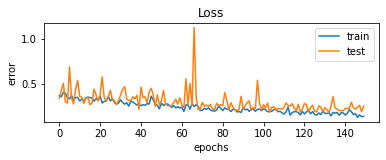

In [ ]:
trainloss8, trainaccuracy8 = model8.evaluate(X_trains, y_trainc, verbose=0)
testloss8,testaccuracy8 = model8.evaluate(X_tests, y_testc, verbose=0)
print('Train: %.3f, Test: %.3f' % (trainaccuracy8, testaccuracy8))
# plot loss during training

pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(output9.history['loss'], label='train')
pyplot.plot(output9.history['val_loss'], label='test')
pyplot.xlabel('epochs')
pyplot.ylabel('error')

pyplot.legend()

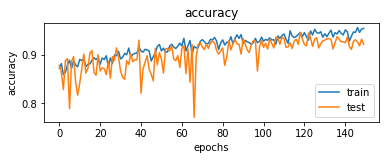

In [ ]:

pyplot.subplot(211)
pyplot.title('accuracy')
pyplot.plot(output9.history['accuracy'], label='train')
pyplot.plot(output9.history['val_accuracy'], label='test')
pyplot.xlabel('epochs')
pyplot.ylabel('accuracy')

pyplot.legend()

The model with 12 conv layer and 1 fully connected layer performs better with traning accuracy of 96 and validation accuracy of 92%

Predicting classes against validation data

In [ ]:
y_predict = model8.predict_classes(X_tests)
y_predict.shape

(950,)

In [ ]:
y_val = []
for i in y_testc:
  y_val.append(np.argmax(i))

confusion matrix


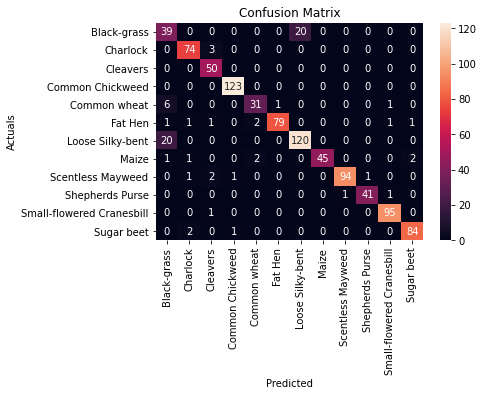

In [ ]:
#plotting confusion matrix
cm = confusion_matrix(y_predict,y_val)
print('confusion matrix')

class_label = class_names
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actuals")
plt.show()

In [ ]:
#priting classification report
print(classification_report(y_predict,y_val))

              precision    recall  f1-score   support

           0       0.58      0.66      0.62        59
           1       0.94      0.96      0.95        77
           2       0.88      1.00      0.93        50
           3       0.98      1.00      0.99       123
           4       0.89      0.79      0.84        39
           5       0.99      0.92      0.95        86
           6       0.86      0.86      0.86       140
           7       1.00      0.88      0.94        51
           8       0.99      0.95      0.97        99
           9       0.98      0.95      0.96        43
          10       0.97      0.99      0.98        96
          11       0.97      0.97      0.97        87

    accuracy                           0.92       950
   macro avg       0.92      0.91      0.91       950
weighted avg       0.93      0.92      0.92       950



Class 7(Maize) has been predicted with 100 % accuracy. class(Black-grass) has least accuracy.

In [ ]:
#reading the test image shared by kaggle
imagestest = []

#df = pd.DataFrame(columns=['image_file'])

#for filename in os.listdir("test"):
    
   # print(filename)
for filename in os.listdir("test"):
  if(filename.endswith('.png')):
    imagestest.append('test' + '/' + filename)
                   
          #Add record to the dataframe
         
          

In [ ]:
imagestest[1:5]

['test/003d61042.png',
 'test/00c47e980.png',
 'test/007b3da8b.png',
 'test/0086a6340.png']

In [ ]:
len(imagestest)

794

Get test data for kaggle submission

In [ ]:

img_arraytest = []

for imgtt in range(len(imagestest)):
  #print(imgl)
  outputtest = []
  #print(imgtt)
  imgte = cv2.imread(imagestest[imgtt])
   # dsize
  #print(imgte)
  dsize = (214,214)
    #print(dsize)
  # resize image
  outputtest = cv2.resize(imgte, dsize = dsize,interpolation=cv2.INTER_AREA)
    #newimage = cv2.GaussianBlur(output,(5,5),0)
    #img = load_img(images[imgl])
  img_arraytest.append(outputtest)

In [ ]:
X_testreals = np.array(img_arraytest).astype('float32')/255.0



In [ ]:
#predicting the model classes against test data
preds = model8.predict_classes(X_testreals)



In [ ]:
predictions  = label_encoder.inverse_transform(preds)

In [ ]:
finaldf = pd.DataFrame(columns = [ 'file','species'])

In [ ]:
finaldf['file']= imagestest
finaldf['species'] = predictions 

In [ ]:
finaldf.to_csv('sample_submission2.csv',index=False)

With real time test data model predicted with 92% accuracy. This model looks best among all.

In [ ]:
img_array[2].shape

(214, 214, 3)

Step 10a :Including additional fully connected layer to check if there is improvement in accuracy of the model

In [ ]:

tf.keras.backend.clear_session()
#Initialize the model
model18 = keras.Sequential()

#Add a Convolutional Layer with 32 filters of size 11X11 and activation function as 'ReLU' 
model18.add(BatchNormalization())

model18.add(Conv2D(32, kernel_size=(11, 11),activation='relu',name='conv_1' , padding = 'same',strides = (2,2)))
model18.add(Conv2D(32, (11, 11), activation='relu',name='conv_2',padding = 'same',strides = (2,2)))
model18.add(Conv2D(64, kernel_size=(7, 7),activation='relu',name='conv_3',padding = 'same',strides = (2,2)))
model18.add(MaxPooling2D(pool_size=(2, 2),name='max_1'))
model18.add(Dropout(0.25,name='drop_1'))

model18.add(BatchNormalization())

#Add a Convolutional Layer with 64 filters of size 5X5 and activation function as 'ReLU' 
model18.add(Conv2D(64, kernel_size=(5, 5),activation='relu',name='conv_4',padding = 'same'))
model18.add(Conv2D(64, (5, 5), activation='relu',name='conv_5',padding = 'same'))
model18.add(Conv2D(128, (3, 3), activation='relu',name='conv_6',padding = 'same'))
model18.add(MaxPooling2D(pool_size=(2, 2),name='max_3'))
model18.add(Dropout(0.25,name='drop_2'))

model18.add(BatchNormalization())

#Add a Convolutional Layer with 128 filters of size 3*3 and activation function as 'ReLU' 
model18.add(Conv2D(128, kernel_size=(3, 3),activation='relu',name='conv_7',padding = 'same'))
model18.add(Conv2D(128, (3, 3), activation='relu',name='conv_8',padding = 'same'))
model18.add(Conv2D(256, (3, 3), activation='relu',name='conv_9',padding = 'same'))
model18.add(MaxPooling2D(pool_size=(2, 2),name='max_4'))
model18.add(Dropout(0.25,name='drop_3'))


model18.add(BatchNormalization())
#Add a Convolutional Layer with 256 filters of size 3*3 and activation function as 'ReLU' 

model18.add(Conv2D(256, kernel_size=(3, 3),activation='relu',name='conv_10',padding = 'same'))
model18.add(Conv2D(256, (3, 3), activation='relu',name='conv_11',padding = 'same'))
model18.add(Conv2D(516, (3, 3), activation='relu',name='conv_12',padding = 'same'))
model18.add(MaxPooling2D(pool_size=(2, 2),name='max_5'))
model18.add(Dropout(0.25,name='drop_4'))

model18.add(Flatten())
model18.add(BatchNormalization())
model18.add(Dense(1000, activation='relu',name='dense_1'))
model18.add(Dense(1000, activation='relu',name='dense_2'))
model18.add(Dropout(0.1,name='drop_5'))
model18.add(Dense(12, activation='softmax',name='dense_3'))
model18.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

output18 = model18.fit_generator(img_generator1.flow(X_trains,y_trainc),
                    epochs=100,
                    steps_per_epoch=3799/50,  #Number of training images//batch_size
                    validation_data=(X_tests,y_testc),
                    validation_steps = 950//50, #Number of test images//batch_size
                    callbacks = [model_checkpoint1]
                   )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
76/75 [==============================] - ETA: 0s - loss: 2.4774 - accuracy: 0.1556
Epoch 00001: val_accuracy improved from -inf to 0.14737, saving model to /content/gdrive/My Drive/kaggle/train/plant6.h5
76/75 [==============================] - 22s 288ms/step - loss: 2.4774 - accuracy: 0.1556 - val_loss: 6.9868 - val_accuracy: 0.1474
Epoch 2/100
76/75 [==============================] - ETA: 0s - loss: 1.9955 - accuracy: 0.2534
Epoch 00002: val_accuracy improved from 0.14737 to 0.23368, saving model to /content/gdrive/My Drive/kaggle/train/plant6.h5
76/75 [==============================] - 21s 280ms/step - loss: 1.9955 - accuracy: 0.2534 - val_loss: 2.7804 - val_accuracy: 0.2337
Epoch 3/100
76/75 [==============================] - ETA: 0s - loss: 1.8855 - accuracy: 0.2930
Epoch 00003: val_accuracy did not improve from 0.23368
76/75 [==============================] - 21s 271ms/step - loss: 1.8855 - ac

In [ ]:
output181 = model18.fit_generator(img_generator1.flow(X_trains,y_trainc),
                    epochs=250,
                    initial_epoch=100,
                    steps_per_epoch=3799/50,  #Number of training images//batch_size
                    validation_data=(X_tests,y_testc),
                    validation_steps = 950//50, #Number of test images//batch_size
                    callbacks = [model_checkpoint1]
                   )

Epoch 101/250
76/75 [==============================] - ETA: 0s - loss: 0.3604 - accuracy: 0.8845
Epoch 00101: val_accuracy did not improve from 0.90000
76/75 [==============================] - 20s 269ms/step - loss: 0.3604 - accuracy: 0.8845 - val_loss: 0.2953 - val_accuracy: 0.8968
Epoch 102/250
76/75 [==============================] - ETA: 0s - loss: 0.3396 - accuracy: 0.8808
Epoch 00102: val_accuracy did not improve from 0.90000
76/75 [==============================] - 20s 268ms/step - loss: 0.3396 - accuracy: 0.8808 - val_loss: 0.3551 - val_accuracy: 0.8884
Epoch 103/250
76/75 [==============================] - ETA: 0s - loss: 0.3492 - accuracy: 0.8849
Epoch 00103: val_accuracy improved from 0.90000 to 0.90211, saving model to /content/gdrive/My Drive/kaggle/train/plant6.h5
76/75 [==============================] - 21s 279ms/step - loss: 0.3492 - accuracy: 0.8849 - val_loss: 0.2789 - val_accuracy: 0.9021
Epoch 104/250
76/75 [==============================] - ETA: 0s - loss: 0.3376 -

Train: 0.934, Test: 0.904


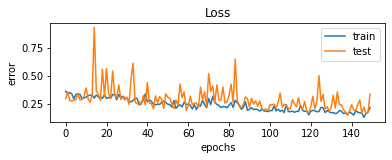

In [ ]:
trainloss8, trainaccuracy8 = model18.evaluate(X_trains, y_trainc, verbose=0)
testloss8,testaccuracy8 = model18.evaluate(X_tests, y_testc, verbose=0)
print('Train: %.3f, Test: %.3f' % (trainaccuracy8, testaccuracy8))
# plot loss during training

pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(output181.history['loss'], label='train')
pyplot.plot(output181.history['val_loss'], label='test')
pyplot.xlabel('epochs')
pyplot.ylabel('error')

pyplot.legend()

Train: 0.934, Test: 0.904


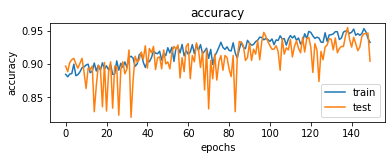

In [ ]:
print('Train: %.3f, Test: %.3f' % (trainaccuracy8, testaccuracy8))
# plot loss during training

pyplot.subplot(211)
pyplot.title('accuracy')
pyplot.plot(output181.history['accuracy'], label='train')
pyplot.plot(output181.history['val_accuracy'], label='test')
pyplot.xlabel('epochs')
pyplot.ylabel('accuracy')

pyplot.legend()

In [ ]:
model18.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, None, None, 3)     12        
_________________________________________________________________
conv_1 (Conv2D)              (None, None, None, 32)    11648     
_________________________________________________________________
conv_2 (Conv2D)              (None, None, None, 32)    123936    
_________________________________________________________________
conv_3 (Conv2D)              (None, None, None, 64)    100416    
_________________________________________________________________
max_1 (MaxPooling2D)         (None, None, None, 64)    0         
_________________________________________________________________
drop_1 (Dropout)             (None, None, None, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 64)    2

This model uses 5,006,606 parametes

In [ ]:
y_predict1 = model18.predict_classes(X_tests)

In [ ]:
pred_index = np.argmax(y_predict1[0])

In [ ]:
pred_index

0

There is no improvement in accuracy with the additional fully connected layer in the existing model

Step 8 :Using transfer learning to check for improvement in model performance. Using VGGnet to check the model performance.

In [ ]:
base_model1 = tf.keras.applications.VGG16(include_top=False, #Do not include classification layer for imagenet
                                       input_shape=(224,224,3),
                                       weights='imagenet')

In [ ]:
from keras.applications.vgg16  import preprocess_input

In [ ]:
preprocess_input()

In [ ]:
img_generator2 = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    #rescale =  1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range = 0.2,
    horizontal_flip=True,
    vertical_flip = True,
   )

In [ ]:
img_generator2.fit(X_trains)


Viewing image without using preprocessing input of vgg

---



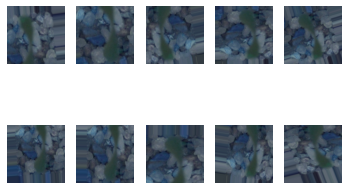

In [ ]:
from matplotlib import pyplot as plt
gen = img_generator2.flow(X_trains[10:11], batch_size=3)

for i in range(1, 11):
    #plt.figure(figsize=(10,10))
    plt.subplot(2,5,i)
    plt.axis("off")
    #plt.imshow(gen.next().squeeze())
    plt.imshow((gen.next()*255).astype(np.uint8).squeeze())
    plt.plot()
plt.show()

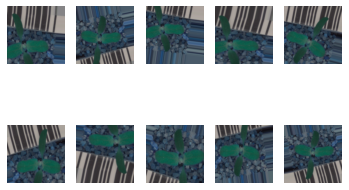

In [ ]:
from matplotlib import pyplot as plt
gen = img_generator2.flow(X_trains[1:2], batch_size=3)

for i in range(1, 11):
    #plt.figure(figsize=(10,10))
    plt.subplot(2,5,i)
    plt.axis("off")
    #plt.imshow(gen.next().squeeze())
    plt.imshow((gen.next()*255).astype(np.uint8).squeeze())
    plt.plot()
plt.show()

In [ ]:
img_generator3 = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    #rescale =  1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range = 0.2,
    horizontal_flip=True,
    vertical_flip = True,
    preprocessing_function = preprocess_input
   )

In [ ]:
img_generator3.fit(X_trains)

Viewing image with preprocess input of vggnet

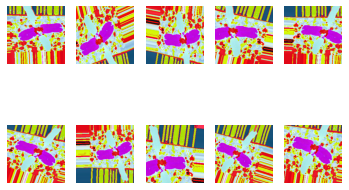

In [ ]:
from matplotlib import pyplot as plt
gen = img_generator3.flow(X_trains[1:2], batch_size=3)

for i in range(1, 11):
    #plt.figure(figsize=(10,10))
    plt.subplot(2,5,i)
    plt.axis("off")
    #plt.imshow(gen.next().squeeze())
    plt.imshow((gen.next()*255).astype(np.uint8).squeeze())
    plt.plot()
plt.show()

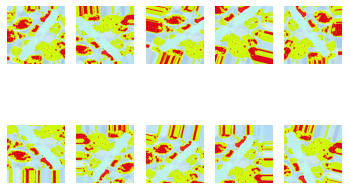

In [ ]:
from matplotlib import pyplot as plt
gen = img_generator3.flow(X_trains[96:97], batch_size=3)

for i in range(1, 11):
    #plt.figure(figsize=(10,10))
    plt.subplot(2,5,i)
    plt.axis("off")
    #plt.imshow(gen.next().squeeze())
    plt.imshow((gen.next()*255).astype(np.uint8).squeeze())
    plt.plot()
plt.show()

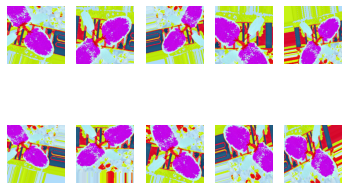

In [ ]:
from matplotlib import pyplot as plt
gen = img_generator3.flow(X_trains[50:51], batch_size=3)

for i in range(1, 11):
    #plt.figure(figsize=(10,10))
    plt.subplot(2,5,i)
    plt.axis("off")
    #plt.imshow(gen.next().squeeze())
    plt.imshow((gen.next()*255).astype(np.uint8).squeeze())
    plt.plot()
plt.show()

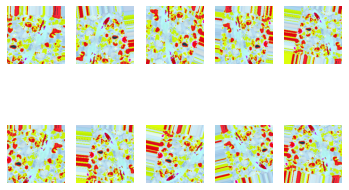

In [ ]:
from matplotlib import pyplot as plt
gen = img_generator3.flow(X_trains[60:61], batch_size=3)

for i in range(1, 11):
    #plt.figure(figsize=(10,10))
    plt.subplot(2,5,i)
    plt.axis("off")
    #plt.imshow(gen.next().squeeze())
    plt.imshow((gen.next()*255).astype(np.uint8).squeeze())
    plt.plot()
plt.show()

Step 9 :Build different models with transfer learning and check the models performance.
Model1: with all layers freeing
Model 2 : usign few layers
Model3 :using all the layers

In [ ]:
len(base_model1.layers)

19

In [ ]:
#freezing all the layers
for layer in base_model1.layers:
    layer.trainable = False


In [ ]:
base_model1.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 214, 214, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 214, 214, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 214, 214, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 107, 107, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 107, 107, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 107, 107, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 53, 53, 128)       0     

In [ ]:
#get Output layer of Pre0trained model
x = base_model1.output

#Global average pool to reduce number of features and Flatten the output
g = tf.keras.layers.GlobalAveragePooling2D()(x)



In [ ]:
prediction = tf.keras.layers.Dense(len(class_names),activation='softmax')(g)

In [ ]:
#Saving the best model using model checkpoint callback
model_checkpoint2=tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/kaggle/train/plant6.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

In [ ]:
final_modelT = tf.keras.models.Model(inputs=base_model1.input,outputs=prediction) #Pre-trained model input as input layer)
final_modelT.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])







In [ ]:
final_modelT.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 214, 214, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 214, 214, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 214, 214, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 107, 107, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 107, 107, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 107, 107, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 53, 53, 128)      

In [ ]:
#building model without applying preprocessing techniques of VGGnet
outputT = final_modelT.fit_generator(img_generator2.flow(X_trains,y_trainc),
                    epochs=5,
                    steps_per_epoch=3799/50,  #Number of training images//batch_size
                    validation_data=(X_tests,y_testc),
                    validation_steps = 950//50, #Number of test images//batch_size
                    callbacks = [model_checkpoint2])

Epoch 1/5
76/75 [==============================] - ETA: 0s - loss: 2.3056 - accuracy: 0.2130WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0101s vs `on_test_batch_end` time: 0.0998s). Check your callbacks.

Epoch 00001: val_accuracy improved from -inf to 0.28316, saving model to /content/gdrive/My Drive/kaggle/train/plant6.h5
76/75 [==============================] - 26s 343ms/step - loss: 2.3056 - accuracy: 0.2130 - val_loss: 2.2165 - val_accuracy: 0.2832
Epoch 2/5
76/75 [==============================] - ETA: 0s - loss: 2.2078 - accuracy: 0.2844
Epoch 00002: val_accuracy improved from 0.28316 to 0.34947, saving model to /content/gdrive/My Drive/kaggle/train/plant6.h5
76/75 [==============================] - 24s 316ms/step - loss: 2.2078 - accuracy: 0.2844 - val_loss: 2.1434 - val_accuracy: 0.3495
Epoch 3/5
76/75 [==============================] - ETA: 0s - loss: 2.1441 - accuracy: 0.2952
Epoch 00003: val_accuracy did not impro

In [ ]:
outputT = final_modelT.fit_generator(img_generator2.flow(X_trains,y_trainc),
                    epochs=50,
                    initial_epoch = 5,
                    steps_per_epoch=3799/50,  #Number of training images//batch_size
                    validation_data=(X_tests,y_testc),
                    validation_steps = 950//50, #Number of test images//batch_size
                    callbacks = [model_checkpoint2])

Epoch 6/50
76/75 [==============================] - ETA: 0s - loss: 1.9932 - accuracy: 0.3438WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0086s vs `on_test_batch_end` time: 0.1023s). Check your callbacks.

Epoch 00006: val_accuracy did not improve from 0.37684
76/75 [==============================] - 23s 307ms/step - loss: 1.9932 - accuracy: 0.3438 - val_loss: 1.9359 - val_accuracy: 0.3663
Epoch 7/50
76/75 [==============================] - ETA: 0s - loss: 1.9594 - accuracy: 0.3586
Epoch 00007: val_accuracy improved from 0.37684 to 0.38842, saving model to /content/gdrive/My Drive/kaggle/train/plant6.h5
76/75 [==============================] - 24s 317ms/step - loss: 1.9594 - accuracy: 0.3586 - val_loss: 1.9104 - val_accuracy: 0.3884
Epoch 8/50
76/75 [==============================] - ETA: 0s - loss: 1.9411 - accuracy: 0.3690
Epoch 00008: val_accuracy improved from 0.38842 to 0.41053, saving model to /content/gdrive/My Drive/k

Train: 0.559, Test: 0.518


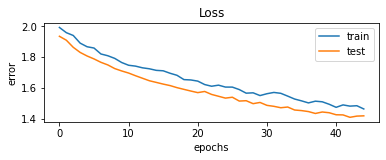

In [ ]:
trainlossT, trainaccuracyT = final_modelT.evaluate(X_trains, y_trainc, verbose=0)
testlossT,testaccuracyT = final_modelT.evaluate(X_tests, y_testc, verbose=0)
print('Train: %.3f, Test: %.3f' % (trainaccuracyT, testaccuracyT))
# plot loss during training

pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(outputT.history['loss'], label='train')
pyplot.plot(outputT.history['val_loss'], label='test')
pyplot.xlabel('epochs')
pyplot.ylabel('error')

pyplot.legend()

There is no improvement in accuracy using VGGnet with transfer learning with all the parameters frozen

unfreezing 5 layers in VGGnet to check model performace.

In [ ]:
for layer in base_model1.layers[14:]:
    layer.trainable = True
for layer in base_model1.layers[:14]:
    layer.trainable = False


In [ ]:
final_modelT.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
final_modelT,

In [ ]:
outputFT = final_modelT.fit_generator(img_generator2.flow(X_trains,y_trainc),
                    epochs=10,
                    steps_per_epoch=3799/50,  #Number of training images//batch_size
                    validation_data=(X_tests,y_testc),
                    validation_steps = 950//50, #Number of test images//batch_size
                    callbacks = [model_checkpoint2])

Epoch 1/10
76/75 [==============================] - ETA: 0s - loss: 2.4405 - accuracy: 0.1456WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0103s vs `on_test_batch_end` time: 0.0998s). Check your callbacks.

Epoch 00001: val_accuracy did not improve from 0.14737
76/75 [==============================] - 25s 328ms/step - loss: 2.4405 - accuracy: 0.1456 - val_loss: 2.4185 - val_accuracy: 0.1474
Epoch 2/10
76/75 [==============================] - ETA: 0s - loss: 2.4163 - accuracy: 0.1349
Epoch 00002: val_accuracy did not improve from 0.14737
76/75 [==============================] - 24s 322ms/step - loss: 2.4163 - accuracy: 0.1349 - val_loss: 2.4179 - val_accuracy: 0.1474
Epoch 3/10
76/75 [==============================] - ETA: 0s - loss: 2.4172 - accuracy: 0.1321
Epoch 00003: val_accuracy did not improve from 0.14737
76/75 [==============================] - 25s 326ms/step - loss: 2.4172 - accuracy: 0.1321 - val_loss: 2.4205 - val_a

With VGGNet model accuracy does not improve using with 5 layers unfrozen. Will use Resnet50 to observe the model performance

In [ ]:
#using Resnet50
base_model2 = tf.keras.applications.ResNet50(include_top=False, 
                                       input_shape=(224,224,3),
                                       weights='imagenet')

In [ ]:
x1 = base_model2.output

#Global average pool to reduce number of features and Flatten the output
g1 = tf.keras.layers.GlobalAveragePooling2D()(x1)


prediction1 = tf.keras.layers.Dense(len(class_names),activation='softmax')(g1)

In [ ]:
for layer in base_model2.layers:
    layer.trainable = False

In [ ]:
final_modelT3 = tf.keras.models.Model(inputs=base_model2.input,outputs=prediction1) #Pre-trained model input as input layer)
final_modelT3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:

#Saving the best model using model checkpoint callback
model_checkpoint3=tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/kaggle/train/plant6.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

In [ ]:
outputT3 = final_modelT3.fit_generator(img_generator2.flow(X_trains,y_trainc),
                    epochs=5,
                    steps_per_epoch=3799/50,  #Number of training images//batch_size
                    validation_data=(X_tests,y_testc),
                    validation_steps = 950//50, #Number of test images//batch_size
                    callbacks = [model_checkpoint3])



Epoch 1/5
76/75 [==============================] - ETA: 0s - loss: 2.4625 - accuracy: 0.1176WARNING:tensorflow:Model was constructed with shape (None, 224, 224, 3) for input Tensor("input_10:0", shape=(None, 224, 224, 3), dtype=float32), but it was called on an input with incompatible shape (50, 214, 214, 3).

Epoch 00001: val_accuracy improved from -inf to 0.14316, saving model to /content/gdrive/My Drive/kaggle/train/plant6.h5
76/75 [==============================] - 26s 344ms/step - loss: 2.4625 - accuracy: 0.1176 - val_loss: 2.4326 - val_accuracy: 0.1432
Epoch 2/5
76/75 [==============================] - ETA: 0s - loss: 2.4439 - accuracy: 0.1312
Epoch 00002: val_accuracy did not improve from 0.14316
76/75 [==============================] - 24s 320ms/step - loss: 2.4439 - accuracy: 0.1312 - val_loss: 2.4190 - val_accuracy: 0.1432
Epoch 3/5
76/75 [==============================] - ETA: 0s - loss: 2.4463 - accuracy: 0.1193
Epoch 00003: val_accuracy did not improve from 0.14316
76/75 [

In [ ]:
outputT3 = final_modelT3.fit_generator(img_generator3.flow(X_trains,y_trainc),
                    epochs=5,
                    steps_per_epoch=3799/50,  #Number of training images//batch_size
                    validation_data=(X_tests,y_testc),
                    validation_steps = 950//50, #Number of test images//batch_size
                    callbacks = [model_checkpoint3])

Epoch 1/5
76/75 [==============================] - ETA: 0s - loss: 2.4616 - accuracy: 0.1205WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0132s vs `on_test_batch_end` time: 0.0702s). Check your callbacks.

Epoch 00001: val_accuracy did not improve from 0.15474
76/75 [==============================] - 24s 312ms/step - loss: 2.4616 - accuracy: 0.1205 - val_loss: 2.5170 - val_accuracy: 0.1032
Epoch 2/5
76/75 [==============================] - ETA: 0s - loss: 2.4404 - accuracy: 0.1234
Epoch 00002: val_accuracy did not improve from 0.15474
76/75 [==============================] - 23s 302ms/step - loss: 2.4404 - accuracy: 0.1234 - val_loss: 2.4860 - val_accuracy: 0.1032
Epoch 3/5
76/75 [==============================] - ETA: 0s - loss: 2.4545 - accuracy: 0.1168
Epoch 00003: val_accuracy did not improve from 0.15474
76/75 [==============================] - 22s 295ms/step - loss: 2.4545 - accuracy: 0.1168 - val_loss: 2.5094 - val_accu

NO improvement in the model accuracy without using preprocessing input,with all layers frozen. We will use transfer learning at later step by freezing different layer and observe model performace.

Step 10 :Using opencv using preprocessing techniques like background masking to check if there is improvement in model accuracy .

In [ ]:

img_array = []
labels = []
#print(images)
#print(images[2])
#print(images.split('/',1))
for imgl in range(len(images)):
  #print(imgl)
  output = []
  if imgl == 2900:
    print(imgl)
  else:
    img = cv2.imread(images[imgl])
   # dsize
    dsize = (214,214)
    #print(dsize)
  # resize image
    output = cv2.resize(img, dsize = dsize,interpolation=cv2.INTER_AREA)
    newimage = cv2.GaussianBlur(output,(5,5),0)
    hsv = cv2.cvtColor(newimage, cv2.COLOR_BGR2HSV)
    lower_green = (25, 35, 55)
    upper_green = (80, 255, 255)
    #masking everything except green
    mask = cv2.inRange(hsv,lower_green,upper_green)
    mask1 = cv2.bitwise_and(newimage,newimage,mask = mask)
    #img = load_img(images[imgl])
    img_array.append(mask1)
    labels.append(classes[imgl])
  
 
# convert to numpy arr ay
 

2900


In [ ]:
#plt.imshow((out * 255).astype(np.uint8)).

In [ ]:
arraydf = pd.DataFrame(columns=['imgarray','lables'])

In [ ]:
arraydf['imgarray'] = img_array
arraydf['lables'] = labels
arraydf.to_csv('arraydf.csv',index=False)

In [ ]:
label_encoder = LabelEncoder()
convlabel1 = label_encoder.fit_transform(labels)

In [ ]:
convlabel1[2000:2012]

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [ ]:
img_array[0].shape

(214, 214, 3)

In [ ]:

X_train2,X_test2, y_train2, y_test2 = train_test_split(img_array,convlabel1,test_size=0.20,random_state=42)

In [ ]:
X_test2[0].shape

(214, 214, 3)

In [ ]:
y_trainc2 = tf.keras.utils.to_categorical(y_train2)
y_testc2 = tf.keras.utils.to_categorical(y_test2)

In [ ]:
X_trains2 = np.array(X_train2).astype('float32')/255.0
X_tests2 = np.array(X_test2).astype('float32')/255.0


In [ ]:
img_generator2 = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip = True,                                                                
                                                                ) 
img_generator2.fit(X_trains2)

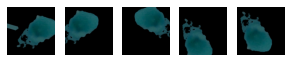

In [ ]:
#viewing background masked train images
from matplotlib import pyplot as plt
gen = img_generator2.flow(X_trains2[0:1], batch_size=1)
for i in range(1, 6):
    plt.subplot(1,6,i)
    plt.axis("off")
    plt.imshow(gen.next().squeeze(), cmap='gray')
    plt.plot()
plt.show()

In [ ]:
from matplotlib import pyplot as plt
x  = img_generator2.flow(X_trains2, batch_size=1).next()


In [ ]:
model_checkpoint1=tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/kaggle/train/plant6.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

In [ ]:
import tensorflow as tf
from keras.layers import BatchNormalization
tf.keras.backend.clear_session()
#Initialize the model
model9 = keras.Sequential()

#Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'ReLU' 
model9.add(BatchNormalization())

model9.add(Conv2D(32, kernel_size=(11, 11),activation='relu',name='conv_1' , padding = 'same',strides = (2,2)))
model9.add(Conv2D(32, (11, 11), activation='relu',name='conv_2',padding = 'same',strides = (2,2)))
model9.add(Conv2D(64, kernel_size=(7, 7),activation='relu',name='conv_3',padding = 'same',strides = (2,2)))
model9.add(MaxPooling2D(pool_size=(2, 2),name='max_1'))
model9.add(Dropout(0.25,name='drop_1'))

model9.add(BatchNormalization())

model9.add(Conv2D(64, kernel_size=(5, 5),activation='relu',name='conv_4',padding = 'same'))
model9.add(Conv2D(64, (5, 5), activation='relu',name='conv_5',padding = 'same'))
model9.add(Conv2D(128, (3, 3), activation='relu',name='conv_6',padding = 'same'))
model9.add(MaxPooling2D(pool_size=(2, 2),name='max_3'))
model9.add(Dropout(0.25,name='drop_2'))

model9.add(BatchNormalization())

model9.add(Conv2D(128, kernel_size=(3, 3),activation='relu',name='conv_7',padding = 'same'))
model9.add(Conv2D(128, (3, 3), activation='relu',name='conv_8',padding = 'same'))
model9.add(Conv2D(256, (3, 3), activation='relu',name='conv_9',padding = 'same'))
model9.add(MaxPooling2D(pool_size=(2, 2),name='max_4'))
model9.add(Dropout(0.25,name='drop_3'))

model9.add(BatchNormalization())

model9.add(Conv2D(256, kernel_size=(3, 3),activation='relu',name='conv_10',padding = 'same'))
model9.add(Conv2D(256, (3, 3), activation='relu',name='conv_11',padding = 'same'))
model9.add(Conv2D(516, (3, 3), activation='relu',name='conv_12',padding = 'same'))
model9.add(MaxPooling2D(pool_size=(2, 2),name='max_5'))
model9.add(Dropout(0.25,name='drop_4'))

model9.add(Flatten())
model9.add(BatchNormalization())
model9.add(Dense(1000, activation='relu',name='dense_1'))
model9.add(Dropout(0.25,name='drop_5'))
model9.add(Dense(12, activation='softmax',name='dense_2'))
model9.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5,verbose = 1,mode ='auto')
output11 = model9.fit_generator(img_generator2.flow(X_trains2,y_trainc2),
                    epochs=50,
                    steps_per_epoch=3799/50,  #Number of training images//batch_size
                    validation_data=(X_tests2,y_testc2),
                    validation_steps = 950//50, #Number of test images//batch_size
                    callbacks = [model_checkpoint1]
                   )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
76/75 [==============================] - ETA: 0s - loss: 2.3219 - accuracy: 0.2381
Epoch 00001: val_accuracy improved from -inf to 0.06000, saving model to /content/gdrive/My Drive/kaggle/train/plant6.h5
76/75 [==============================] - 23s 298ms/step - loss: 2.3219 - accuracy: 0.2381 - val_loss: 19.5993 - val_accuracy: 0.0600
Epoch 2/50
76/75 [==============================] - ETA: 0s - loss: 2.1309 - accuracy: 0.2656
Epoch 00002: val_accuracy improved from 0.06000 to 0.08316, saving model to /content/gdrive/My Drive/kaggle/train/plant6.h5
76/75 [==============================] - 23s 301ms/step - loss: 2.1309 - accuracy: 0.2656 - val_loss: 9.9598 - val_accuracy: 0.0832
Epoch 3/50
76/75 [==============================] - ETA: 0s - loss: 1.9638 - accuracy: 0.3109
Epoch 00003: val_accuracy did not improve from 0.08316
76/75 [==============================] - 22s 289ms/step - loss: 1.9638 - accu

In [ ]:
output12 = model9.fit_generator(img_generator2.flow(X_trains2,y_trainc2),
                    epochs=300,
                    initial_epoch =50,
                    steps_per_epoch=3799/50,  #Number of training images//batch_size
                    validation_data=(X_tests2,y_testc2),
                    validation_steps = 950//50, #Number of test images//batch_size
                    callbacks = [model_checkpoint1]
                   )

Epoch 51/300
76/75 [==============================] - ETA: 0s - loss: 0.5997 - accuracy: 0.8031
Epoch 00051: val_accuracy did not improve from 0.83895
76/75 [==============================] - 22s 286ms/step - loss: 0.5997 - accuracy: 0.8031 - val_loss: 0.6319 - val_accuracy: 0.7737
Epoch 52/300
76/75 [==============================] - ETA: 0s - loss: 0.5470 - accuracy: 0.8262
Epoch 00052: val_accuracy did not improve from 0.83895
76/75 [==============================] - 22s 286ms/step - loss: 0.5470 - accuracy: 0.8262 - val_loss: 0.5684 - val_accuracy: 0.8158
Epoch 53/300
76/75 [==============================] - ETA: 0s - loss: 0.5661 - accuracy: 0.8155
Epoch 00053: val_accuracy improved from 0.83895 to 0.84316, saving model to /content/gdrive/My Drive/kaggle/train/plant6.h5
76/75 [==============================] - 22s 295ms/step - loss: 0.5661 - accuracy: 0.8155 - val_loss: 0.4660 - val_accuracy: 0.8432
Epoch 54/300
76/75 [==============================] - ETA: 0s - loss: 0.5510 - acc

KeyboardInterrupt: ignored

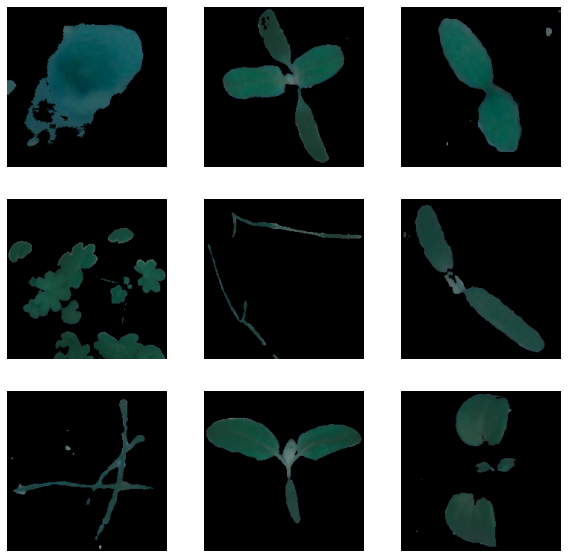

In [ ]:
#viewing the image
plt.figure(figsize=(10, 10))
for i, (image) in enumerate(X_trains2[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    #plt.title(int(label))
    plt.axis("off")

In [ ]:
model9.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, None, None, 3)     12        
_________________________________________________________________
conv_1 (Conv2D)              (None, None, None, 32)    11648     
_________________________________________________________________
conv_2 (Conv2D)              (None, None, None, 32)    123936    
_________________________________________________________________
conv_3 (Conv2D)              (None, None, None, 64)    100416    
_________________________________________________________________
max_1 (MaxPooling2D)         (None, None, None, 64)    0         
_________________________________________________________________
drop_1 (Dropout)             (None, None, None, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 64)    2

In [ ]:
model9.evaluate(X_trains2, y_trainc2)

19/19 [==============================] - 0s 19ms/step - loss: 0.2743 - accuracy: 0.9168


[0.27433568239212036, 0.9168421030044556]

In [ ]:
model9.evaluate(X_tests2, y_testc2)

19/19 [==============================] - 0s 19ms/step - loss: 0.2743 - accuracy: 0.9168


[0.27433568239212036, 0.9168421030044556]

In [ ]:
y_predict = model9.predict_classes(X_tests2)
y_predict.shape

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


(950,)

confusion matrix


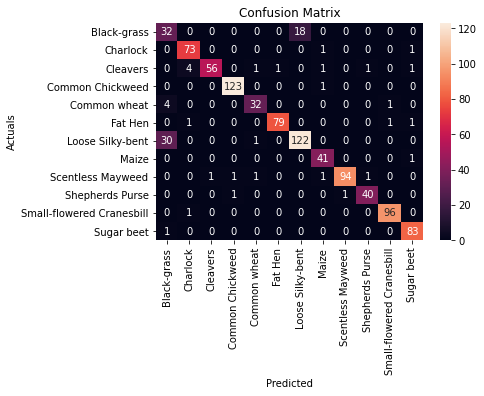

In [ ]:


y_val = []
for i in y_testc2:
  y_val.append(np.argmax(i))

cm = confusion_matrix(y_predict,y_val)
print('confusion matrix')

class_label = class_names
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actuals")
plt.show()



In [ ]:
print(classification_report(y_predict,y_val))

              precision    recall  f1-score   support

           0       0.48      0.64      0.55        50
           1       0.92      0.97      0.95        75
           2       0.98      0.86      0.92        65
           3       0.98      0.99      0.99       124
           4       0.91      0.86      0.89        37
           5       0.99      0.96      0.98        82
           6       0.87      0.80      0.83       153
           7       0.91      0.98      0.94        42
           8       0.99      0.95      0.97        99
           9       0.95      0.95      0.95        42
          10       0.98      0.99      0.98        97
          11       0.95      0.99      0.97        84

    accuracy                           0.92       950
   macro avg       0.91      0.91      0.91       950
weighted avg       0.92      0.92      0.92       950



With masked images model accuracy drops by 1 % also the accuracy of class 1 has been reduced to 48% from 58%.

Train: 0.917, Test: 0.917


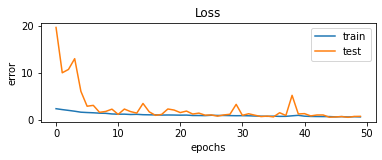

In [ ]:
trainloss1, trainaccuracy1 = model9.evaluate(X_trains2, y_trainc2, verbose=0)
testloss1,testaccuracy1 = model9.evaluate(X_tests2, y_testc2, verbose=0)
print('Train: %.3f, Test: %.3f' % (trainaccuracy1, testaccuracy1))
# plot loss during training

pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(output11.history['loss'], label='train')
pyplot.plot(output11.history['val_loss'], label='test')
pyplot.xlabel('epochs')
pyplot.ylabel('error')

pyplot.legend()

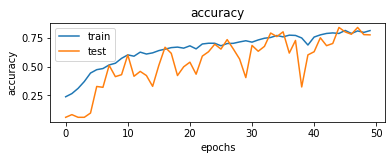

In [ ]:
pyplot.subplot(211)
pyplot.title('accuracy')
pyplot.plot(output11.history['accuracy'], label='train')
pyplot.plot(output11.history['val_accuracy'], label='test')
pyplot.xlabel('epochs')
pyplot.ylabel('accuracy')

pyplot.legend()

There is no improvement in accuracy of the model with masked background.

In [ ]:
maskdf = pd.read_csv('train.csv')

In [ ]:
maskdf.head()

,class,image_file
0,Black-grass,train/Black-grass/0050f38b3.png
1,Black-grass,train/Black-grass/0183fdf68.png
2,Black-grass,train/Black-grass/0260cffa8.png
3,Black-grass,train/Black-grass/075d004bc.png
4,Black-grass,train/Black-grass/05eedce4d.png


# Step 11 :using tranfer learning to check the model performance by training the model with pre trained weights using Resnet and using flowfrom_dataframe 

In [ ]:
base_model = tf.keras.applications.ResNet50(include_top=False, #Do not include classification layer for imagenet
                                       input_shape=(214,214,3),
                                       weights='imagenet')

In [ ]:
#reading from datafrom which was formed earlier with the image data
train_df, test_df = train_test_split(newdf, test_size=0.2, random_state=42)

In [ ]:
train_df.head(3)

,class,image_file
3052,Maize,train/Maize/a30702538.png
2223,Fat Hen,train/Fat Hen/f180203df.png
1498,Common Chickweed,train/Common Chickweed/ea395710d.png


In [ ]:
def normalize_data(img):
    
    #Normalize for ResNet50
    
    return tf.keras.applications.resnet50.preprocess_input(img)

In [ ]:
from  keras.applications.resnet50 import preprocess_input

In [ ]:
newdf

,class,image_file
0,Black-grass,train/Black-grass/0050f38b3.png
1,Black-grass,train/Black-grass/0183fdf68.png
2,Black-grass,train/Black-grass/0260cffa8.png
3,Black-grass,train/Black-grass/075d004bc.png
4,Black-grass,train/Black-grass/05eedce4d.png
...,...,...
4745,Sugar beet,train/Sugar beet/fc293eacb.png
4746,Sugar beet,train/Sugar beet/fc441208c.png
4747,Sugar beet,train/Sugar beet/fed9406b2.png
4748,Sugar beet,train/Sugar beet/fef5e7066.png


In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=normalize_data)

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    preprocessing_function = normalize_data
    )

In [ ]:
train_generator = train_datagen.flow_from_dataframe(train_df, x_col='image_file', #File path for image
                                                    y_col='class', 
                                                    #Class for the image
                                                    target_size=(214, 214), #Image resize dimensions
                                                    batch_size=50)

Found 3800 validated image filenames belonging to 12 classes.


In [ ]:
test_generator = test_datagen.flow_from_dataframe(test_df, x_col='image_file', #File path for image
                                                    y_col='class',  
                                                            #Class for the image
                                                    target_size=(214, 214), #Image resize dimensions
                                                    batch_size=50,
                                                  )

Found 950 validated image filenames belonging to 12 classes.


In [ ]:
test_generatorFi = test_datagen.flow_from_dataframe(test_df, x_col='image_file', #File path for image
                                                    y_col='class',  
                                                            #Class for the image
                                                    target_size=(214, 214), #Image resize dimensions
                                                    batch_size=1,shuffle = False)

Found 950 validated image filenames belonging to 12 classes.


In [ ]:
x , y = next(test_generator)

In [ ]:
x1 , y1 = next(test_generator)

In [ ]:
x1.shape , y1.shape 

((50, 214, 214, 3), (50, 12))

In [ ]:
y[0] ,y[1]

(array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32))

In [ ]:
x.shape , y.shape

((50, 214, 214, 3), (50, 12))

In [ ]:
len(base_model.layers)

175

In [ ]:
#freezing all the layers
for layer in base_model.layers[165:]:
    layer.trainable = True

In [ ]:
#freezing all the layers
for layer in base_model.layers[0:165]:
    layer.trainable = False

In [ ]:
base_model.output

<tf.Tensor 'conv5_block3_out/Relu_5:0' shape=(None, 7, 7, 2048) dtype=float32>

In [ ]:
#get Output layer of Pre0trained model
x = base_model.output

#Global average pool to reduce number of features and Flatten the output
g = tf.keras.layers.GlobalAveragePooling2D()(x)



In [ ]:
l = tf.keras.layers.Dense(1000)(g)
d = tf.keras.layers.Dropout(0.25)(l)
prediction = tf.keras.layers.Dense(len(class_names),activation='softmax')(d)

In [ ]:
final_modelTr = tf.keras.models.Model(inputs=base_model.input, #Pre-trained model input as input layer
                                    outputs=prediction) #Output layer added

In [ ]:
final_modelTr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
final_modelTr.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 214, 214, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 220, 220, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 107, 107, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 107, 107, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
model uses 6,526,676 parameters

SyntaxError: ignored

In [ ]:
#Saving the best model using model checkpoint callback
model_checkpointnew =tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/kaggle/train/plantTransferF.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

In [ ]:
outputT2 = final_modelTr.fit_generator(train_generator,
                    epochs=5,
                    steps_per_epoch=3800/50,  #Number of training images//batch_size
                    validation_data=(test_generator),
                    validation_steps = 950//50, #Number of test images//batch_size
                    callbacks = [model_checkpointnew])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
76/76 [==============================] - ETA: 0s - loss: 1.3028 - accuracy: 0.6895
Epoch 00001: val_accuracy improved from -inf to 0.74737, saving model to /content/gdrive/My Drive/kaggle/train/plantTransferF.h5
76/76 [==============================] - 95s 1s/step - loss: 1.3028 - accuracy: 0.6895 - val_loss: 2.1401 - val_accuracy: 0.7474
Epoch 2/5
76/76 [==============================] - ETA: 0s - loss: 0.4727 - accuracy: 0.8487
Epoch 00002: val_accuracy improved from 0.74737 to 0.82316, saving model to /content/gdrive/My Drive/kaggle/train/plantTransferF.h5
76/76 [==============================] - 86s 1s/step - loss: 0.4727 - accuracy: 0.8487 - val_loss: 0.7812 - val_accuracy: 0.8232
Epoch 3/5
76/76 [==============================] - ETA: 0s - loss: 0.4445 - accuracy: 0.8674
Epoch 00003: val_accuracy did not improve from 0.82316
76/76 [==============================] - 85s 1s/step - loss: 0.4445 - a

In [ ]:
outputT2 = final_modelTr.fit_generator(train_generator,
                    epochs=10,
                    initial_epoch =5,
                    steps_per_epoch=3800/50,  #Number of training images//batch_size
                    validation_data=(test_generator),
                    validation_steps = 950//50, #Number of test images//batch_size
                    callbacks = [model_checkpointnew])

Epoch 6/10
76/76 [==============================] - ETA: 0s - loss: 0.2384 - accuracy: 0.9208
Epoch 00006: val_accuracy did not improve from 0.89579
76/76 [==============================] - 85s 1s/step - loss: 0.2384 - accuracy: 0.9208 - val_loss: 0.8547 - val_accuracy: 0.8653
Epoch 7/10
76/76 [==============================] - ETA: 0s - loss: 0.2445 - accuracy: 0.9161
Epoch 00007: val_accuracy improved from 0.89579 to 0.91684, saving model to /content/gdrive/My Drive/kaggle/train/plantTransferF.h5
76/76 [==============================] - 86s 1s/step - loss: 0.2445 - accuracy: 0.9161 - val_loss: 0.2923 - val_accuracy: 0.9168
Epoch 8/10
76/76 [==============================] - ETA: 0s - loss: 0.2555 - accuracy: 0.9155
Epoch 00008: val_accuracy did not improve from 0.91684
76/76 [==============================] - 87s 1s/step - loss: 0.2555 - accuracy: 0.9155 - val_loss: 0.4321 - val_accuracy: 0.8895
Epoch 9/10
76/76 [==============================] - ETA: 0s - loss: 0.1812 - accuracy: 0.

In [ ]:
test_generator.reset()



In [ ]:
Y_predT = final_modelTr.predict(test_generatorFi)


In [ ]:
y_true = test_generator.classes

In [ ]:
len(Y_predT)

950

In [ ]:
y_predn = []
for i in Y_predT:
  y_predn.append(np.argmax(i))


In [ ]:
y_true = []
pred = []
i = 0
while i < 950:
    i = i+1
    x, y = next(test_generatorFi)
    pred.append(final_modelTr.predict(x[0].reshape(1,214,214,3)))
    y_true.append(y[0]) 


In [ ]:
#confusion_matrix(pred,y_true)
len(pred),pred[1:10]

(950, [array([[5.6674155e-11, 3.0434691e-12, 1.6439244e-05, 9.9992514e-01,
          6.4697070e-13, 3.0661362e-11, 7.4869733e-10, 2.0744272e-10,
          5.7986515e-05, 4.1198550e-07, 9.4755519e-09, 6.9538264e-12]],
        dtype=float32),
  array([[1.3069021e-12, 5.0424287e-10, 1.9332250e-10, 7.5244396e-14,
          1.7465290e-11, 9.9997878e-01, 3.1543670e-12, 5.3429819e-13,
          3.1439947e-15, 1.3100693e-12, 8.4065845e-14, 2.1216871e-05]],
        dtype=float32),
  array([[6.3270000e-14, 1.8753930e-08, 1.0333692e-13, 8.1887919e-18,
          7.9207770e-21, 2.5429062e-15, 1.4310944e-13, 2.7663078e-22,
          4.0270263e-15, 1.6014832e-11, 1.0000000e+00, 2.2394823e-21]],
        dtype=float32),
  array([[3.6925869e-16, 1.5033121e-19, 8.9345414e-10, 1.0000000e+00,
          7.4750889e-18, 1.7442129e-18, 6.9405549e-15, 7.2363329e-15,
          2.0018055e-08, 4.9160576e-14, 3.6926696e-17, 7.8292852e-18]],
        dtype=float32),
  array([[1.8461451e-14, 7.0629380e-07, 4.0919386e-

In [ ]:
y_pred=[]
y_tru = []
for i in pred:
  y_pred.append(np.argmax(i))
  
  

In [ ]:
for j in y_true:
  y_tru.append(np.argmax(j))

In [ ]:
Y_predn =[]
for t in Y_predT:
  Y_predn.append(np.argmax(t))

In [ ]:
len(y_true),y_tru[1:10],y_pred[1:10], Y_predn[1:10]

(950,
 [3, 5, 10, 3, 10, 11, 11, 11, 5],
 [3, 5, 10, 3, 10, 2, 11, 11, 0],
 [5, 6, 4, 11, 1, 3, 3, 2, 4])

In [ ]:

Y_predn[1:10], test_generatorFi.classes[1:10]

([9, 10, 2, 5, 6, 1, 3, 3, 2], [3, 1, 5, 4, 11, 9, 8, 3, 5])

confusion matrix


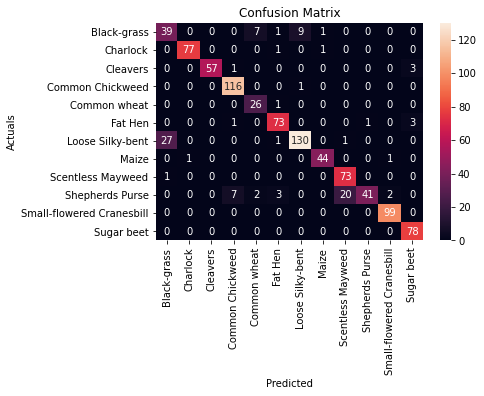

In [ ]:
cm = confusion_matrix(y_pred,y_tru)
print('confusion matrix')

class_label = class_names
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actuals")
plt.show()

In [ ]:
print(classification_report(y_pred,y_tru))

              precision    recall  f1-score   support

           0       0.58      0.68      0.63        57
           1       0.99      0.97      0.98        79
           2       1.00      0.93      0.97        61
           3       0.93      0.99      0.96       117
           4       0.74      0.96      0.84        27
           5       0.91      0.94      0.92        78
           6       0.93      0.82      0.87       159
           7       0.96      0.96      0.96        46
           8       0.78      0.99      0.87        74
           9       0.98      0.55      0.70        75
          10       0.97      1.00      0.99        99
          11       0.93      1.00      0.96        78

    accuracy                           0.90       950
   macro avg       0.89      0.90      0.89       950
weighted avg       0.91      0.90      0.90       950



Using transfer learning we could achieve similar performance in lesser epochs. Running this model for more epochs will result in increase in accuracy

In [ ]:
# y_img_batch, y_class_batch = test_generator[0] 
# y_pred = np.argmax(final_modelTr.predict(y_img_batch),-1)
# y_true = np.argmax(y_class_batch,-1)

In [ ]:
# def plot_confusion_matrix(cm, classes, figname,
#  normalize=False,title='Confusion matrix',
#  cmap=plt.cm.Blues):
 
#  import numpy as np
#  import matplotlib.pyplot as plt
#  import itertools
#  if normalize:
#    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#    print("Normalized confusion matrix")
#  else:
#    print("Confusion matrix, without normalization")
#    plt.figure(figsize=(8,8))
#    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#    plt.title(title)
#    #plt.colorbar()
#    tick_marks = np.arange(len(classes))
#    plt.xticks(tick_marks, classes, rotation=90)
#    plt.yticks(tick_marks, classes)
#    fmt = '.2f' if normalize else 'd'
#    thresh = cm.max() / 2.
#  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#    plt.text(j, i, format(cm[i, j], fmt),
#    horizontalalignment="center",
#    color="white" if cm[i, j] > thresh else "black")
#    plt.ylabel("True label")
#    plt.xlabel("Predicted label")
#    plt.tight_layout()
#    plt.savefig(figname)

val_loss: 0.34943512082099915
val_acc: 0.8978947401046753


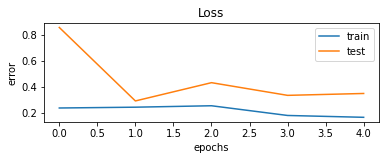

In [ ]:
#final_modelTR.load_weights('/content/gdrive/My Drive/kaggle/train/plant6.h5')

val_loss1, val_acc1 = final_modelTr.evaluate_generator(test_generator)

print('val_loss:', val_loss1)
print('val_acc:', val_acc1)

# plot loss during training

pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(outputT2.history['loss'], label='train')
pyplot.plot(outputT2.history['val_loss'], label='test')
pyplot.xlabel('epochs')
pyplot.ylabel('error')

pyplot.legend()

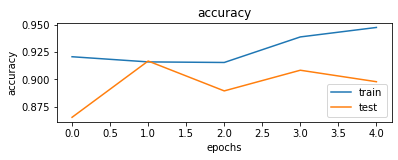

In [ ]:

pyplot.subplot(211)
pyplot.title('accuracy')
pyplot.plot(outputT2.history['accuracy'], label='train')
pyplot.plot(outputT2.history['val_accuracy'], label='test')
pyplot.xlabel('epochs')
pyplot.ylabel('accuracy')

pyplot.legend()

In [ ]:
#unfreezing 5 layers
for layer in base_model.layers[170:]:
    layer.trainable = True
for layer in base_model.layers[0:170]:
    layer.trainable = False

In [ ]:
outputTTrain = final_modelT.fit_generator(train_generator,
                    epochs=5,
                    steps_per_epoch=3800/50,  #Number of training images//batch_size
                    validation_data=(test_generator),
                    validation_steps = 950//50, #Number of test images//batch_size
                    callbacks = [model_checkpoint2])

Epoch 1/5
76/76 [==============================] - ETA: 0s - loss: 0.4065 - accuracy: 0.8718
Epoch 00001: val_accuracy improved from -inf to 0.70211, saving model to /content/gdrive/My Drive/kaggle/train/plant6.h5
76/76 [==============================] - 88s 1s/step - loss: 0.4065 - accuracy: 0.8718 - val_loss: 1.7022 - val_accuracy: 0.7021
Epoch 2/5
76/76 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.9137
Epoch 00002: val_accuracy improved from 0.70211 to 0.82737, saving model to /content/gdrive/My Drive/kaggle/train/plant6.h5
76/76 [==============================] - 87s 1s/step - loss: 0.2560 - accuracy: 0.9137 - val_loss: 0.7088 - val_accuracy: 0.8274
Epoch 3/5
76/76 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.9239
Epoch 00003: val_accuracy improved from 0.82737 to 0.85579, saving model to /content/gdrive/My Drive/kaggle/train/plant6.h5
76/76 [==============================] - 87s 1s/step - loss: 0.2065 - accuracy: 0.9239 - val_l

In [ ]:
outputTTrain2 = final_modelT.fit_generator(train_generator,
                    epochs=25,
                    initial_epoch = 5,
                    steps_per_epoch=3800/50,  #Number of training images//batch_size
                    validation_data=(test_generator),
                    validation_steps = 950//50, #Number of test images//batch_size
                    callbacks = [model_checkpoint2])

Epoch 6/25
76/76 [==============================] - ETA: 0s - loss: 0.1594 - accuracy: 0.9432
Epoch 00006: val_accuracy did not improve from 0.89158
76/76 [==============================] - 86s 1s/step - loss: 0.1594 - accuracy: 0.9432 - val_loss: 0.4306 - val_accuracy: 0.8737
Epoch 7/25
76/76 [==============================] - ETA: 0s - loss: 0.1541 - accuracy: 0.9461
Epoch 00007: val_accuracy improved from 0.89158 to 0.90105, saving model to /content/gdrive/My Drive/kaggle/train/plant6.h5
76/76 [==============================] - 87s 1s/step - loss: 0.1541 - accuracy: 0.9461 - val_loss: 0.3552 - val_accuracy: 0.9011
Epoch 8/25
76/76 [==============================] - ETA: 0s - loss: 0.1355 - accuracy: 0.9487
Epoch 00008: val_accuracy did not improve from 0.90105
76/76 [==============================] - 85s 1s/step - loss: 0.1355 - accuracy: 0.9487 - val_loss: 0.5770 - val_accuracy: 0.8358
Epoch 9/25
76/76 [==============================] - ETA: 0s - loss: 0.1295 - accuracy: 0.9561
Epo

In [ ]:
outputTTrain3 = final_modelT.fit_generator(train_generator,
                    epochs=50,
                    initial_epoch = 25,
                    steps_per_epoch=3800/50,  #Number of training images//batch_size
                    validation_data=(test_generator),
                    validation_steps = 950//50, #Number of test images//batch_size
                    callbacks = [model_checkpoint2])

Epoch 26/50
76/76 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.9737
Epoch 00026: val_accuracy did not improve from 0.91368
76/76 [==============================] - 86s 1s/step - loss: 0.0761 - accuracy: 0.9737 - val_loss: 0.4000 - val_accuracy: 0.8789
Epoch 27/50
76/76 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9668
Epoch 00027: val_accuracy improved from 0.91368 to 0.91474, saving model to /content/gdrive/My Drive/kaggle/train/plant6.h5
76/76 [==============================] - 88s 1s/step - loss: 0.0924 - accuracy: 0.9668 - val_loss: 0.3333 - val_accuracy: 0.9147
Epoch 28/50
76/76 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9729
Epoch 00028: val_accuracy did not improve from 0.91474
76/76 [==============================] - 86s 1s/step - loss: 0.0822 - accuracy: 0.9729 - val_loss: 0.3841 - val_accuracy: 0.8842
Epoch 29/50
76/76 [==============================] - ETA: 0s - loss: 0.0736 - accuracy: 0.9729

Using occlusion to predict which are the most important areas for image classification

In [ ]:
import math
patch_size = 40
stride = 20
img = []
img_size = 214
imageo = []
output_width = int(math.ceil(214 - patch_size)/stride + 1)
output_height = int(math.ceil(214 - patch_size)/stride + 1)
img_arr = np.array(images[1:13])
print(img_arr)
print(img_arr[0].shape)


['train/Black-grass/0183fdf68.png' 'train/Black-grass/0260cffa8.png'
 'train/Black-grass/075d004bc.png' 'train/Black-grass/05eedce4d.png'
 'train/Black-grass/078eae073.png' 'train/Black-grass/082314602.png'
 'train/Black-grass/0ace21089.png' 'train/Black-grass/0b228a6b8.png'
 'train/Black-grass/0b3e7a7a9.png' 'train/Black-grass/0bb75ded8.png'
 'train/Black-grass/0be707615.png' 'train/Black-grass/0c67c3fc3.png']
()


In [ ]:
def create_image(images1):
  imgf = cv2.imread(images1)
   # dsize
  dsize = (214,214)
    #print(dsize)
  # resize image
  outputf = cv2.resize(imgf,dsize = dsize)
  return outputf

In [ ]:
imageoa = np.array(imageo).astype('float32')/255

In [ ]:
imageoa.shape

(0,)

In [ ]:
heatmap = np.zeros((output_height, output_width))

train/Black-grass/0183fdf68.png


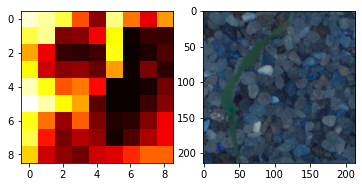

train/Black-grass/0260cffa8.png


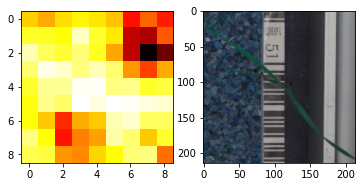

train/Black-grass/075d004bc.png


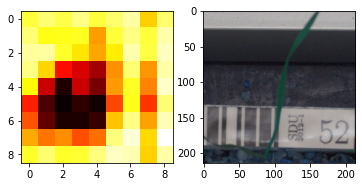

train/Black-grass/05eedce4d.png


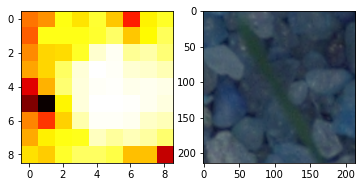

train/Black-grass/078eae073.png


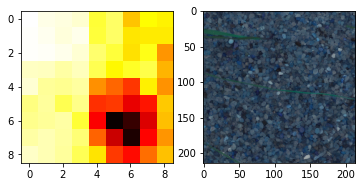

train/Black-grass/082314602.png


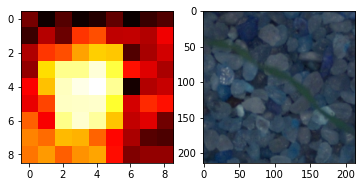

train/Black-grass/0ace21089.png


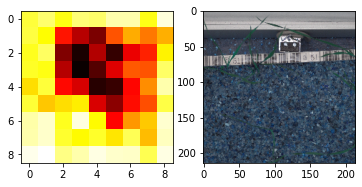

train/Black-grass/0b228a6b8.png


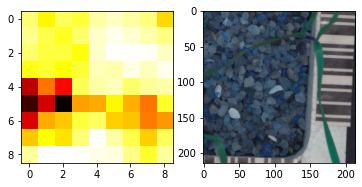

train/Black-grass/0b3e7a7a9.png


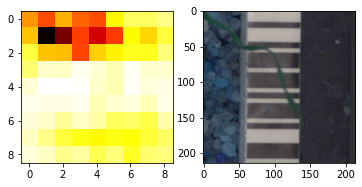

train/Black-grass/0bb75ded8.png


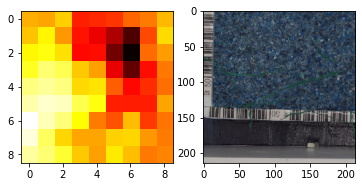

train/Black-grass/0be707615.png


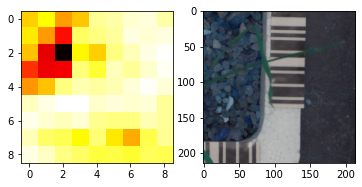

train/Black-grass/0c67c3fc3.png


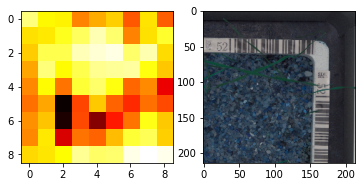

In [ ]:
output_width, output_height
#for im in imageoa[0:5]:
#img_copy = np.copy(imageoa[0])
#print(img_copy[0].shape)
for img in img_arr:
  print(img)
  img = create_image(img)
  img_array1 = np.expand_dims(img, axis=0)
    #Get the index with highest probability
  prediction = final_modelTr.predict(img_array1)
    #print(prediction[0])
  pred_index = np.argmax(prediction[0])

  for h in range(output_height):
    for w in range(output_width):
      h_start = h * stride
      w_start = w * stride
    #Create original image copy
      img_array = img.copy()

            #Update image with the patch
      img_array[h_start:h_start+patch_size, w_start: w_start+patch_size] = 0
            #cv2_imshow(img_array)
            #Create a batch
      img_array = np.expand_dims(img_array, axis=0)
            
            #Get the prediction
      prediction = final_modelTr.predict(img_array)[0]
            #print(prediction, prediction[pred_index])
            #Probability for right label, store it in the heatmap
      heatmap[h,w] = prediction[pred_index]
  #print(file_name)
  plt.subplot(1,2,1)
  plt.imshow(np.transpose(heatmap,(1,0)), cmap='hot', interpolation='nearest')
  plt.subplot(1,2,2)
  plt.imshow(img)
  plt.show()

In [ ]:
img_arr2 = np.array(images[1000:1013])

train/Common Chickweed/1265c4a42.png


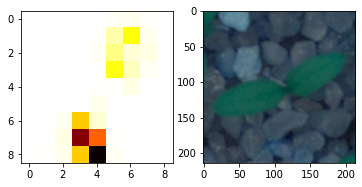

train/Common Chickweed/137dad5ef.png


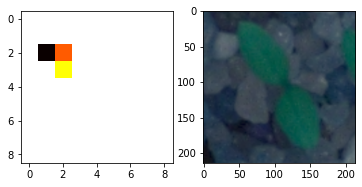

train/Common Chickweed/14486549c.png


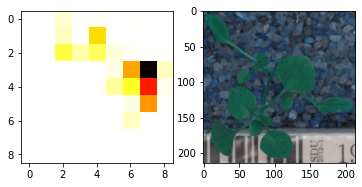

train/Common Chickweed/142c503e1.png


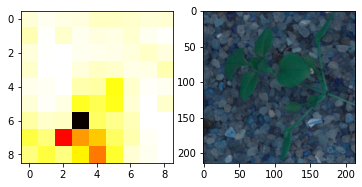

train/Common Chickweed/145b9d73c.png


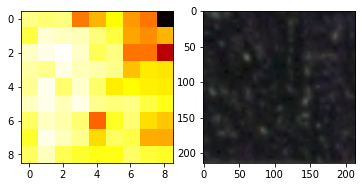

train/Common Chickweed/146feb316.png


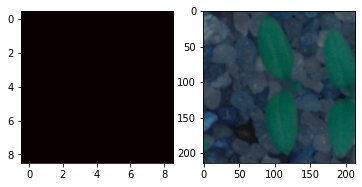

train/Common Chickweed/149f0527e.png


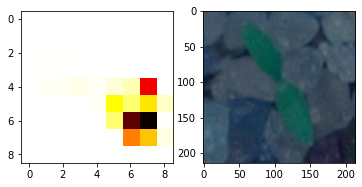

train/Common Chickweed/14b7eab5d.png


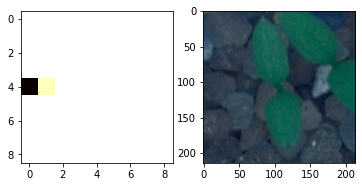

train/Common Chickweed/151a67732.png


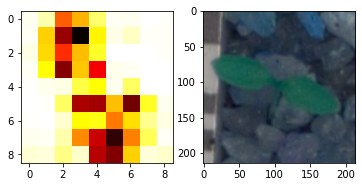

train/Common Chickweed/1599e5ec9.png


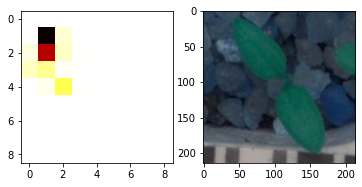

train/Common Chickweed/15cbad146.png


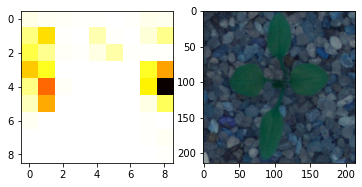

train/Common Chickweed/15f6bed07.png


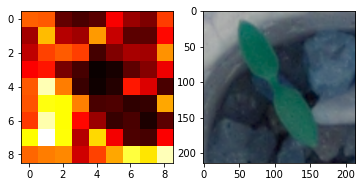

train/Common Chickweed/15ff4b029.png


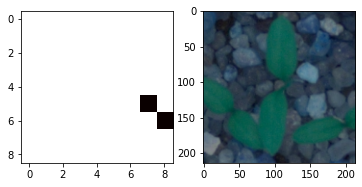

In [ ]:
output_width, output_height
#for im in imageoa[0:5]:
#img_copy = np.copy(imageoa[0])
#print(img_copy[0].shape)
for img in img_arr2:
  print(img)
  img = create_image(img)
  img_array1 = np.expand_dims(img, axis=0)
    #Get the index with highest probability
  prediction = final_modelTr.predict(img_array1)
    #print(prediction[0])
  pred_index = np.argmax(prediction[0])

  for h in range(output_height):
    for w in range(output_width):
      h_start = h * stride
      w_start = w * stride
    #Create original image copy
      img_array = img.copy()

            #Update image with the patch
      img_array[h_start:h_start+patch_size, w_start: w_start+patch_size] = 0
            #cv2_imshow(img_array)
            #Create a batch
      img_array = np.expand_dims(img_array, axis=0)
            
            #Get the prediction
      prediction = final_modelTr.predict(img_array)[0]
            #print(prediction, prediction[pred_index])
            #Probability for right label, store it in the heatmap
      heatmap[h,w] = prediction[pred_index]
  #print(file_name)
  plt.subplot(1,2,1)
  plt.imshow(np.transpose(heatmap,(1,0)), cmap='hot', interpolation='nearest')
  plt.subplot(1,2,2)
  plt.imshow(img)
  plt.show()

Mostly model has learned from the plant and in some cases background information is given priority which could be misclassification of an image

Conclusion : 
 The plant seedling classification model was built using only fully connected layers, fully convolutional layers, Convolutional layers,using image augmentation, transfer learning.

 The model was overfitting when built with only fully connected layers.this model had overfitting problem training accuracy was 100% and validation accuracy was 50%.

 The overfitting reduced in convolutional model along with drop out layers.

 Image augmentaion optimization technique was used to further avoid overfitting and improved accuracy of the model.
 
 The best model accuracy was train : 96%, val data: 92% and test data : 92%. This was achieved with 12 convolutional layer and 2 fully connected layers with various filter, adam optimizer and Relu activation function.
 The best accuracy was achieved after 250 epochs

 Adding additional fully connected layer to the above model does not show any significant improvement in model accuracy.

 Model built with preprocessed image(masked image) shown drop in model accuracy by 1%.

 Tried two different model for transfer learning. VGGNet and Resnet.
 Model behaved better with Resnet50. With transfer learning model accuracy reached 89% in initial 10 epochs with pretrained weights and using last 10 layers of the resnet50 model.  The similar accuracy was achieved in around 100 epochs in the convolution model without transfer learning.

 With transfer learning various was of implementing was tried with array as well as using flow_from_dataframe and with flow_from_Dataframe. Model was normalized by using prepocessing_inputs of Resnet50

We can conclude that image augmentation techniques and transfer learning helps to reduce overfitting problem.

 Also we could observe the model is suffering from class imbalance problem. Using class imbalance techniques can help in reaching 100 % accuracy of the model.
